
# Problem Statement:
    ### We aim to understand the behavioral differences between casual riders and members, and see if we can develop a marketing strategy to convert casual riders into annual members.

### Solution Steps:

1. [Data importation](#1.Data-importation)

2. [Exploratory data analysis, data cleaning, and Feature engineering](#2.Exploratory-data-analysis,data-cleaning,and-Feature-engineering)

3. [Data preprocessing for modelling](#3.Data-preprocessing-for-modelling)

4. [Summary](#8.Summary)


## Package Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2
import datetime as dt
import geopy.distance as gd
import warnings
warnings.filterwarnings('ignore')

## Data importation

In [2]:
# must get all the csv's and combine them and analyze together. Get 1 year's worth of data
# 202208-divvy-tripdata.zip
months = ['202208','202209','202210','202211','202212','202301','202302','202303','202304','202305','202306','202307']
df = pd.DataFrame()

for m in months:
  r = urllib2.urlopen("https://divvy-tripdata.s3.amazonaws.com/" + m + "-divvy-tripdata.zip").read()
  file = ZipFile(BytesIO(r))

  if m == '202209':
    tripdata_csv = file.open(m + "-divvy-publictripdata.csv")
  else:
    tripdata_csv = file.open(m + "-divvy-tripdata.csv")

  monthly_df = pd.read_csv(tripdata_csv)
  if(monthly_df.shape[0] == 0):
    print('Month ' + m + ' had no values')
    # if any csv was not read in or was blank, notify me!
  df = pd.concat([df, monthly_df])

df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,NaN,NaN,NaN,NaN,41.89,-87.64,41.92,-87.64,casual
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,NaN,NaN,NaN,NaN,41.97,-87.69,41.97,-87.66,casual
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,NaN,NaN,NaN,NaN,41.94,-87.65,41.97,-87.69,casual
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,NaN,NaN,NaN,NaN,41.85,-87.65,41.84,-87.66,casual


### Sanity Checks

In [3]:
df['started_at'].min() #first date started is where I expect

'2022-08-01 00:00:00'

In [4]:
df['started_at'].max() #last date started is where I expect

'2023-07-31 23:59:56'

In [5]:
#checking shape of data
df.shape

(5723606, 13)

In [6]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [7]:
#overall overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5723606 entries, 0 to 767649
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 611.3+ MB


**Observation: most data types are objects, some are floats**


## Calculate the duration of each ride in hours

In [8]:
df['ride_duration (hr)'] = (pd.to_datetime(df['ended_at']) - pd.to_datetime(df['started_at'])) /  np.timedelta64(1, 'h')

In [9]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr)
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,NaN,NaN,NaN,NaN,41.93,-87.69,41.94,-87.72,casual,0.125278
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,NaN,NaN,NaN,NaN,41.89,-87.64,41.92,-87.64,casual,0.233889
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,NaN,NaN,NaN,NaN,41.97,-87.69,41.97,-87.66,casual,0.178889
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,NaN,NaN,NaN,NaN,41.94,-87.65,41.97,-87.69,casual,0.250833
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,NaN,NaN,NaN,NaN,41.85,-87.65,41.84,-87.66,casual,0.097778


### Check for missing values

In [10]:
#check missing values
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    868772
start_station_id      868904
end_station_name      925008
end_station_id        925149
start_lat                  0
start_lng                  0
end_lat                 6102
end_lng                 6102
member_casual              0
ride_duration (hr)         0
dtype: int64

### Observation:

There are many missing values from start and end station names and ids. We should investigate why there are so many missing station names. Possibly, there is a problem broken hardware not registering the station, or perhaps users drop off the bike somewhere not at a station.

The end latitude and longitude also have many missing values, while the starting lat and lng values are all there. One possible explanation is that the users pick up the bikes from stations (so we have the lat and lng), but they drop off the bike at untracked locations.

### Check duplicates on ride_id

In [11]:
df.duplicated(subset='ride_id').sum()

0

## Explore Categorical Variables

In [12]:
categorical_var = df.select_dtypes(include = 'object').columns
numerical_var = df.select_dtypes(include = np.number).columns

categorical_var, numerical_var

(Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
        'start_station_name', 'start_station_id', 'end_station_name',
        'end_station_id', 'member_casual'],
       dtype='object'),
 Index(['start_lat', 'start_lng', 'end_lat', 'end_lng', 'ride_duration (hr)'], dtype='object'))

**Observation: Many missing values in the start_station_name, start_station_id, end_station_name, end_station_id, and end_lat, end_long**

** No duplicates in the ride_id


In [13]:
def explore_cat_var(df,col):
    '''
    This function return a summary of a categorical variable.

    '''
    unique_categories = df[col].nunique()   #count the number of unique values in the column
    print('Summary')
    print('==========')
    print(df[col].describe(),'\n')

    if unique_categories <=5:
        sns.countplot(x=col,data=df) #if variables are fewer than or equal to 5, we can create a horizontal bar chart
        plt.show()
    elif 5 < unique_categories <=20:
        sns.countplot(y=col,data=df) #if variables are greater than 5, we can create a horizontal bar chart
        plt.show()
    else:
        pass
    print('==============================================')
    print('Value counts \n')
    print(df[col].value_counts(),'\n')
    print('==============================================')
    print('Number of Missing values: {}'.format(df[col].isnull().sum()))

In [14]:
def fillna_values(df, col, fill_value):
  df[col].fillna(fill_value, inplace=True)
  print("Number of Missing Values: " + str(df[col].isnull().sum()) + "\n")
  print("After replacing null values \n")
  print(df[col].value_counts())

### Explore Categorical Variable: rideable_type

Summary
count           5723606
unique                3
top       electric_bike
freq            3110425
Name: rideable_type, dtype: object 



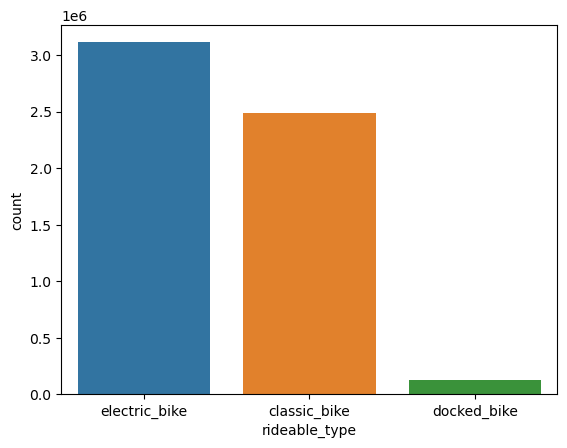

Value counts 

rideable_type
electric_bike    3110425
classic_bike     2484277
docked_bike       128904
Name: count, dtype: int64 

Number of Missing values: 0


In [15]:
explore_cat_var(df, "rideable_type")

In [50]:
bike_type_df = df.groupby(["rideable_type", "member_casual"])["ride_id"].count()\
    .reset_index(name='Count')\
    .rename(columns={"member_casual":"Member Type", "rideable_type":"Bike Type"})


bike_type_df

,Bike Type,Member Type,Count
0,classic_bike,casual,791154
1,classic_bike,member,1693123
2,docked_bike,casual,128904
3,electric_bike,casual,1249497
4,electric_bike,member,1860928


posx and posy should be finite values
posx and posy should be finite values


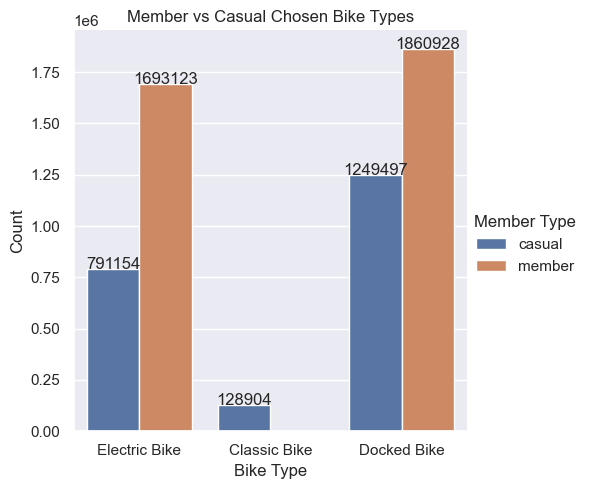

In [55]:
# ax = sns.countplot(x="rideable_type",data=df) #if variables are fewer than or equal to 5, we can create a horizontal bar chart
sns.set(rc={"figure.figsize":(12,6)})
g = sns.catplot(x='Bike Type', y='Count', data=bike_type_df, kind='bar', errorbar=None, hue="Member Type")
g.set(xlabel="Bike Type",ylabel="Count", xticklabels=["Electric Bike", "Classic Bike", "Docked Bike"], title="Member vs Casual Chosen Bike Types")

ax = g.facet_axis(0, 0)

for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height, 
 s = "{:.0f}".format(height),  
 ha = "center")

plt.show()

There are over an order of magnitude fewer docked bikes chosen as rides than other bike types. It is likely that riding a docked bike is a poor user experience than riding the other bike types.

### Explore Categorical Variable: started_at

In [17]:
explore_cat_var(df, "started_at")

Summary
count                 5723606
unique                4821003
top       2022-10-03 17:22:27
freq                        8
Name: started_at, dtype: object 

Value counts 

started_at
2022-10-03 17:22:27    8
2023-07-13 17:38:08    8
2022-10-24 16:59:45    8
2023-06-23 17:51:51    7
2023-07-13 18:00:14    7
                      ..
2022-11-10 17:31:16    1
2022-11-01 15:56:41    1
2022-11-09 21:44:21    1
2022-11-10 18:00:50    1
2023-07-07 18:47:27    1
Name: count, Length: 4821003, dtype: int64 

Number of Missing values: 0


### Explore Categorical Variable: ended_at

In [18]:
explore_cat_var(df, "ended_at")

Summary
count                 5723606
unique                4833101
top       2022-08-22 12:47:49
freq                       20
Name: ended_at, dtype: object 

Value counts 

ended_at
2022-08-22 12:47:49    20
2023-04-10 09:24:22    12
2023-03-22 17:30:49    11
2023-03-21 16:59:40    10
2023-07-13 07:30:44    10
                       ..
2022-11-06 20:05:26     1
2022-11-14 07:54:26     1
2022-11-07 04:54:13     1
2022-11-28 04:54:51     1
2023-07-07 18:51:46     1
Name: count, Length: 4833101, dtype: int64 

Number of Missing values: 0


### Explore Categorical Variable: start_station_name

In [19]:
explore_cat_var(df, "start_station_name")

Summary
count                     4854834
unique                       1801
top       Streeter Dr & Grand Ave
freq                        67214
Name: start_station_name, dtype: object 

Value counts 

start_station_name
Streeter Dr & Grand Ave                          67214
DuSable Lake Shore Dr & Monroe St                39572
Michigan Ave & Oak St                            37876
DuSable Lake Shore Dr & North Blvd               36587
Clark St & Elm St                                35699
                                                 ...  
Public Rack - Lavergne Ave & Belle Plaine Ave        1
Back of the Yards Park                               1
Public Rack - East End Ave & 75th St                 1
Newland Ave & Diversey Ave                           1
Public Rack - Washtenaw Ave & 63rd St                1
Name: count, Length: 1801, dtype: int64 

Number of Missing values: 868772


In [20]:
fillna_values(df, "start_station_name", "Unknown")

Number of Missing Values: 0

After replacing null values 

start_station_name
Unknown                                  868772
Streeter Dr & Grand Ave                   67214
DuSable Lake Shore Dr & Monroe St         39572
Michigan Ave & Oak St                     37876
DuSable Lake Shore Dr & North Blvd        36587
                                          ...  
Cottage Grove Ave & 89th Pl                   1
Plainfield Ave & Irving Park Rd               1
Park Manor Elementary School                  1
Marshfield Ave & 45th St                      1
Public Rack - Washtenaw Ave & 63rd St         1
Name: count, Length: 1802, dtype: int64


In [21]:
most_casual_riders_start_station = df[df["member_casual"]=="casual"].groupby(["start_station_name", "member_casual"])["ride_id"]\
      .count()\
      .reset_index(name='count') \
      .sort_values(['count'], ascending=False)\
      .head(10)

most_casual_riders_start_station

,start_station_name,member_casual,count
1597,Unknown,casual,344295
1574,Streeter Dr & Grand Ave,casual,50026
303,DuSable Lake Shore Dr & Monroe St,casual,30194
667,Michigan Ave & Oak St,casual,23119
674,Millennium Park,casual,22438
304,DuSable Lake Shore Dr & North Blvd,casual,20973
1495,Shedd Aquarium,casual,18706
1579,Theater on the Lake,casual,16757
1636,Wells St & Concord Ln,casual,14061
307,Dusable Harbor,casual,13933


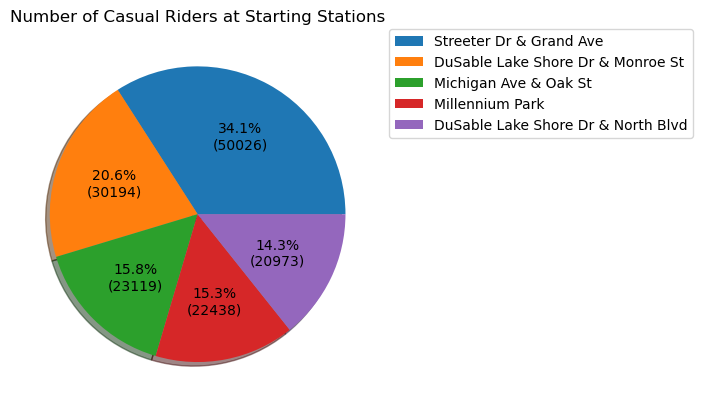

In [52]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
s = most_casual_riders_start_station[["start_station_name", "count"]][1:6]\
    .rename(columns={'count': 'Count'})

ax = s.plot.pie(y='Count', title="Number of Casual Riders at Starting Stations", \
                   autopct=autopct_format(s["Count"]), \
                   shadow=True, startangle=0, labels=s["start_station_name"][:10], 
                   labeldistance=None)
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [56]:
most_member_riders_start_station = df[df["member_casual"]=="member"].groupby(["start_station_name", "member_casual"])["ride_id"]\
      .count()\
      .reset_index(name='count') \
      .sort_values(['count'], ascending=False)\
      .head(10)

most_member_riders_start_station

,start_station_name,member_casual,count
1456,Unknown,member,524477
497,Kingsbury St & Kinzie St,member,25282
183,Clark St & Elm St,member,23971
210,Clinton St & Washington Blvd,member,23101
1493,Wells St & Concord Ln,member,21506
1454,University Ave & 57th St,member,20876
586,Loomis St & Lexington St,member,20525
313,Ellis Ave & 60th St,member,19772
1494,Wells St & Elm St,member,19495
206,Clinton St & Madison St,member,19178


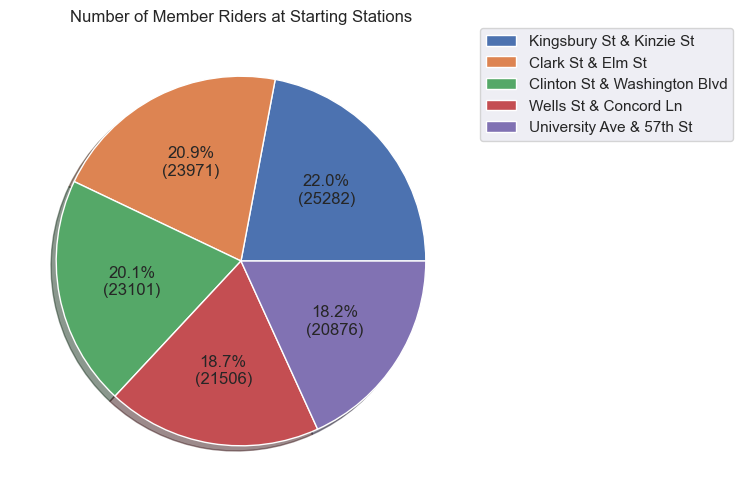

In [57]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
s = most_member_riders_start_station[["start_station_name", "count"]][1:6]\
    .rename(columns={'count': 'Count'})

ax = s.plot.pie(y='Count', title="Number of Member Riders at Starting Stations", \
                   autopct=autopct_format(s["Count"]), \
                   shadow=True, startangle=0, labels=s["start_station_name"][:10], 
                   labeldistance=None)
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

#### Observation:

There are many unknown starting and ending locations, but relatively speaking, fewer missing longitude and latitude points. It could be that many users drop off the bike at a place where we can track the longitude and latitude, but not correlated to a station.

### Explore Categorical Variable: start_station_id

In [58]:
explore_cat_var(df, "start_station_id")

Summary
count     5723606
unique       1503
top       Unknown
freq       868904
Name: start_station_id, dtype: object 

Value counts 

start_station_id
Unknown    868904
13022       67214
13300       39572
13042       37876
LF-005      36587
            ...  
934             1
787             1
880             1
870             1
1080.0          1
Name: count, Length: 1503, dtype: int64 

Number of Missing values: 0


In [59]:
fillna_values(df, "start_station_id", "Unknown")

Number of Missing Values: 0

After replacing null values 

start_station_id
Unknown    868904
13022       67214
13300       39572
13042       37876
LF-005      36587
            ...  
934             1
787             1
880             1
870             1
1080.0          1
Name: count, Length: 1503, dtype: int64


### Explore Categorical Variable: end_station_name

In [60]:
explore_cat_var(df, "end_station_name")

Summary
count     5723606
unique       1800
top       Unknown
freq       925008
Name: end_station_name, dtype: object 

Value counts 

end_station_name
Unknown                                      925008
Streeter Dr & Grand Ave                       67820
DuSable Lake Shore Dr & North Blvd            38675
Michigan Ave & Oak St                         38357
DuSable Lake Shore Dr & Monroe St             37938
                                              ...  
Public Rack - Cottage Grove Ave & 89th Pl         1
Public Rack - Mt Greenwood Library N              1
Public Rack - Kedvale Ave & 63rd St E             1
Public Rack - Lafayette Ave & 87th St SW          1
Public Rack - Stony Is Ave & 73rd St              1
Name: count, Length: 1800, dtype: int64 

Number of Missing values: 0


In [61]:
fillna_values(df, "end_station_name", "Unknown")

Number of Missing Values: 0

After replacing null values 

end_station_name
Unknown                                      925008
Streeter Dr & Grand Ave                       67820
DuSable Lake Shore Dr & North Blvd            38675
Michigan Ave & Oak St                         38357
DuSable Lake Shore Dr & Monroe St             37938
                                              ...  
Public Rack - Cottage Grove Ave & 89th Pl         1
Public Rack - Mt Greenwood Library N              1
Public Rack - Kedvale Ave & 63rd St E             1
Public Rack - Lafayette Ave & 87th St SW          1
Public Rack - Stony Is Ave & 73rd St              1
Name: count, Length: 1800, dtype: int64


In [62]:
most_casual_riders_end_station = df[df["member_casual"]=="casual"].groupby(["end_station_name", "member_casual"])["ride_id"]\
      .count()\
      .reset_index(name='count') \
      .sort_values(['count'], ascending=False)\
      .head(10)

most_casual_riders_end_station

,end_station_name,member_casual,count
1593,Unknown,casual,403481
1570,Streeter Dr & Grand Ave,casual,52722
299,DuSable Lake Shore Dr & Monroe St,casual,27567
668,Michigan Ave & Oak St,casual,24321
675,Millennium Park,casual,24131
300,DuSable Lake Shore Dr & North Blvd,casual,23064
1575,Theater on the Lake,casual,17863
1492,Shedd Aquarium,casual,16629
1630,Wells St & Concord Ln,casual,13586
303,Dusable Harbor,casual,12950


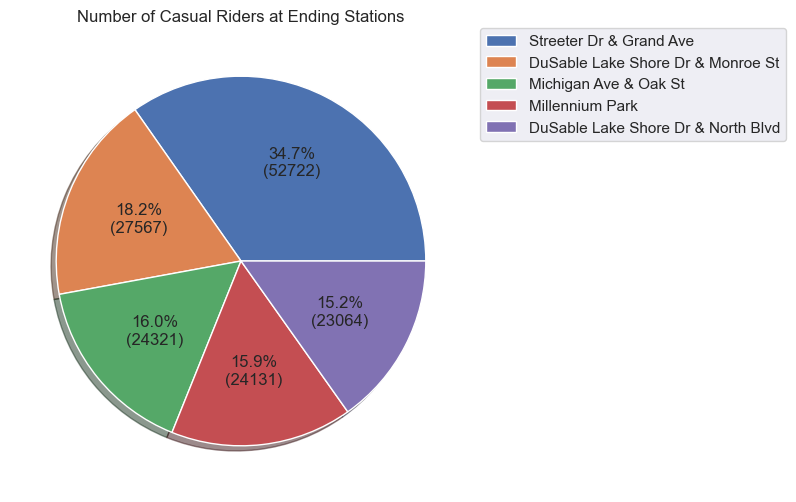

In [63]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
s = most_casual_riders_end_station[["end_station_name", "count"]][1:6]\
    .rename(columns={'count': 'Count'})
# ax = s.plot(kind="pie", autopct=autopct_format(s), shadow=True, explode=[0.05, 0.05], colors=colors, legend=True, title='Number of Member Riders vs Casual Riders', ylabel='count', labeldistance=None)

ax = s.plot.pie(y='Count', title="Number of Casual Riders at Ending Stations", \
                   autopct=autopct_format(s["Count"]), \
                   shadow=True, startangle=0, labels=s["end_station_name"][:10], 
                   labeldistance=None)
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [64]:
most_member_riders_end_station = df[df["member_casual"]=="member"].groupby(["end_station_name", "member_casual"])["ride_id"]\
      .count()\
      .reset_index(name='count') \
      .sort_values(['count'], ascending=False)\
      .head(10)

most_member_riders_end_station

,end_station_name,member_casual,count
1447,Unknown,member,521527
491,Kingsbury St & Kinzie St,member,25488
207,Clinton St & Washington Blvd,member,24148
180,Clark St & Elm St,member,23829
1484,Wells St & Concord Ln,member,22340
1445,University Ave & 57th St,member,21035
580,Loomis St & Lexington St,member,20812
203,Clinton St & Madison St,member,20242
1485,Wells St & Elm St,member,19611
306,Ellis Ave & 60th St,member,19491


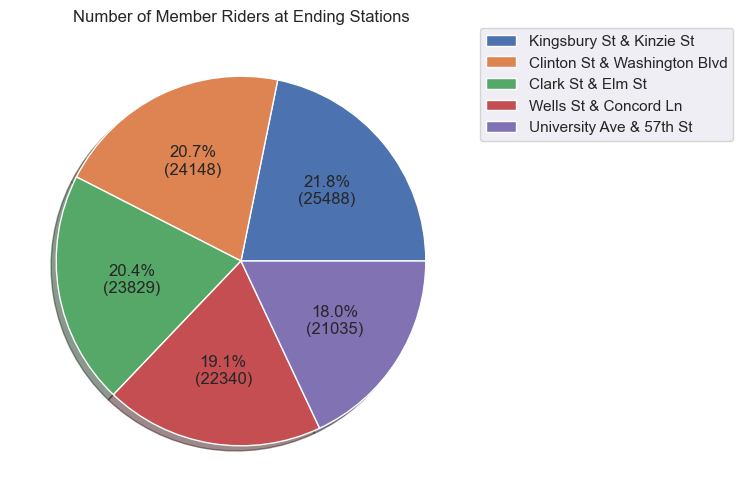

In [65]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
s = most_member_riders_end_station[["end_station_name", "count"]][1:6]\
    .rename(columns={'count': 'Count'})
# ax = s.plot(kind="pie", autopct=autopct_format(s), shadow=True, explode=[0.05, 0.05], colors=colors, legend=True, title='Number of Member Riders vs Casual Riders', ylabel='count', labeldistance=None)

ax = s.plot.pie(y='Count', title="Number of Member Riders at Ending Stations", \
                   autopct=autopct_format(s["Count"]), \
                   shadow=True, startangle=0, labels=s["end_station_name"][:10], 
                   labeldistance=None)
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

### Explore Categorical Variable: end_station_id

In [66]:
explore_cat_var(df, "end_station_id")

Summary
count     5723606
unique       1506
top       Unknown
freq       925149
Name: end_station_id, dtype: object 

Value counts 

end_station_id
Unknown    925149
13022       67820
LF-005      38675
13042       38357
13300       37938
            ...  
985             1
796             1
1260.0          1
1024            1
818             1
Name: count, Length: 1506, dtype: int64 

Number of Missing values: 0


In [67]:
fillna_values(df, "end_station_id", "Unknown")

Number of Missing Values: 0

After replacing null values 

end_station_id
Unknown    925149
13022       67820
LF-005      38675
13042       38357
13300       37938
            ...  
985             1
796             1
1260.0          1
1024            1
818             1
Name: count, Length: 1506, dtype: int64


### Explore Categorical Variable: member_casual

Summary
count     5723606
unique          2
top        member
freq      3554051
Name: member_casual, dtype: object 



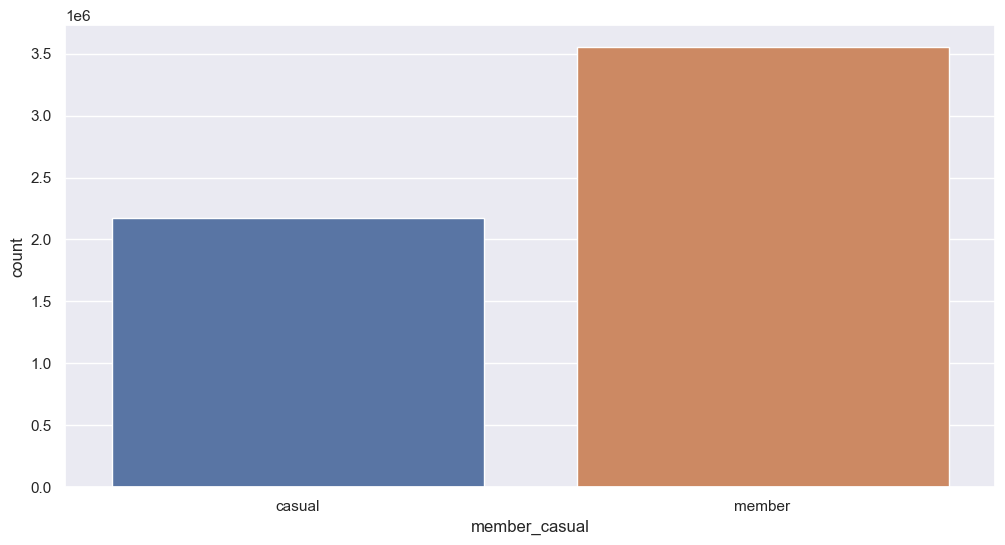

Value counts 

member_casual
member    3554051
casual    2169555
Name: count, dtype: int64 

Number of Missing values: 0


In [68]:
explore_cat_var(df, "member_casual")

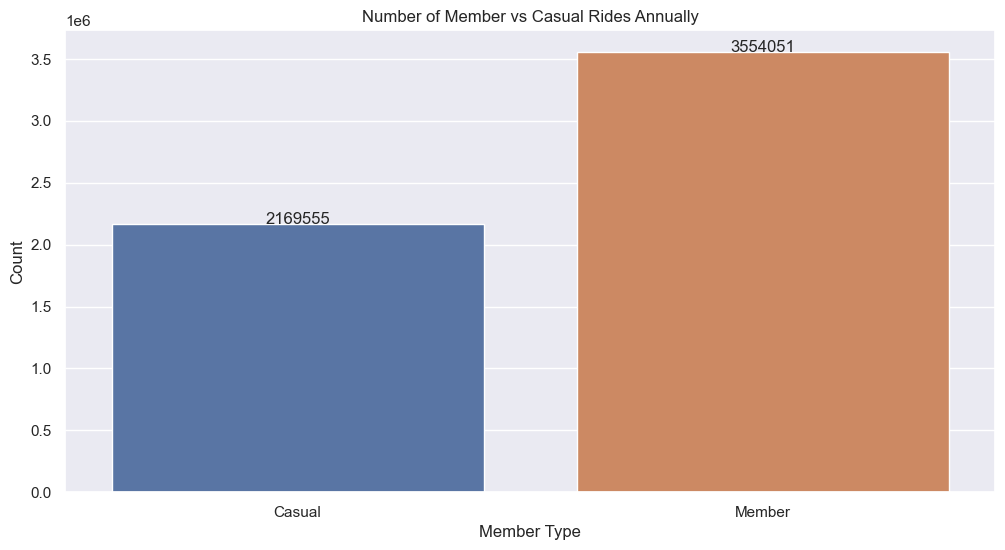

In [69]:
ax = sns.countplot(x="member_casual",data=df) #if variables are fewer than or equal to 5, we can create a horizontal bar chart
ax.set(xlabel="Member Type",ylabel="Count", xticklabels=["Casual", "Member"], title="Number of Member vs Casual Rides Annually")

for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+200, 
 s = "{:.0f}".format(height),  
 ha = "center")

plt.show()

In [70]:
# a function for autoformatting values in a pie chart
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

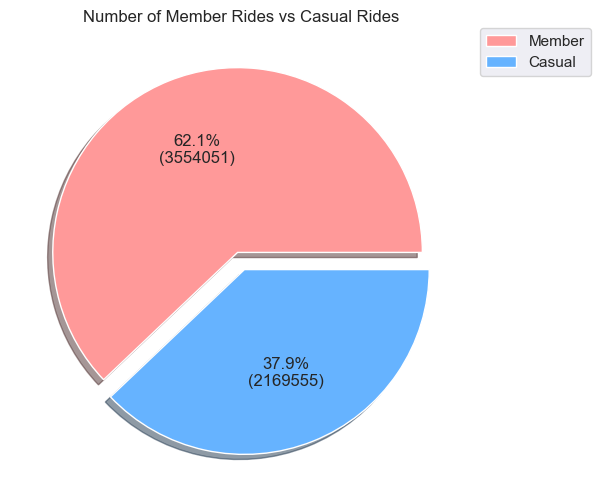

In [71]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
s = df['member_casual'].str.title().value_counts()
ax = s.plot(kind="pie", autopct=autopct_format(s), shadow=True, explode=[0.05, 0.05], colors=colors, legend=True, title='Number of Member Rides vs Casual Rides', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

### Question:
    Are there certain combinations of start and end stations which are more common than others?
    If there are, is there anything unique about these station combinations in terms of member riders vs casual riders?


In [72]:
df['station_routes'] = list(zip(df['start_station_name'], df['end_station_name']))
df['station_routes'].value_counts()

station_routes
(Unknown, Unknown)                                                        410862
(Streeter Dr & Grand Ave, Streeter Dr & Grand Ave)                         10596
(Ellis Ave & 60th St, University Ave & 57th St)                             7475
(DuSable Lake Shore Dr & Monroe St, DuSable Lake Shore Dr & Monroe St)      7372
(Ellis Ave & 60th St, Ellis Ave & 55th St)                                  7020
                                                                           ...  
(Public Rack - Halsted St & 95th St - SE, Public Rack - Brainerd Park)         1
(Public Rack - Vincennes Ave & 95th St, Public Rack - Brainerd Park)           1
(LaSalle St & Jackson Blvd, California Ave & North Ave)                        1
(Maplewood Ave & 59th St, Pulaski Rd & 60th St)                                1
(Unknown, Public Rack - Pulaski & Ardmore)                                     1
Name: count, Length: 177339, dtype: int64

Most station start and end destinations are unknown, but there are some routes more common than others.

The top 4 are:
1. (Streeter Dr & Grand Ave, Streeter Dr & Grand Ave)
2. (Ellis Ave & 60th St, University Ave & 57th St)
3. (DuSable Lake Shore Dr & Monroe St, DuSable Lake Shore Dr & Monroe St)
4. (Ellis Ave & 60th St, Ellis Ave & 55th St)

### Investigation of the top 4 most common routes

1. Starting at: Streeter Dr & Grand Ave

   Ending at: Streeter Dr & Grand Ave

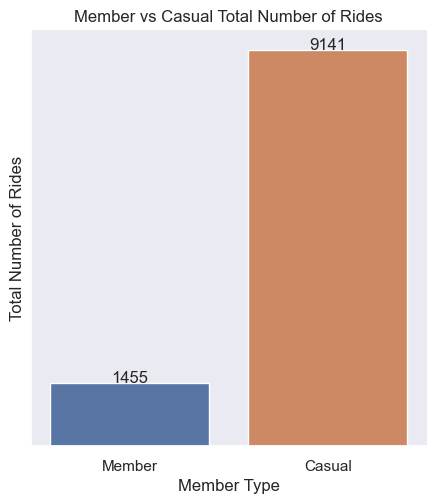

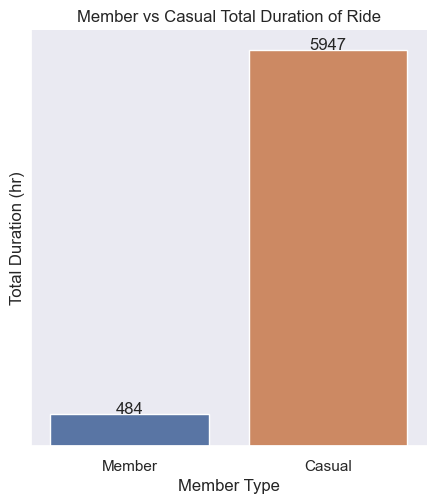

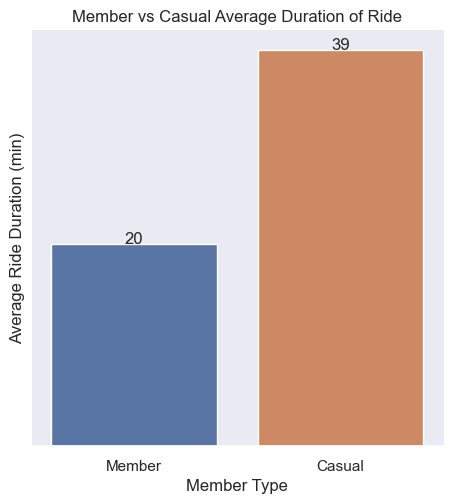

In [74]:
total_duration_hr = df[df['station_routes']== ("Streeter Dr & Grand Ave", "Streeter Dr & Grand Ave")].groupby(['member_casual'])['ride_duration (hr)'].sum()
num_rides = df[df['station_routes']== ("Streeter Dr & Grand Ave", "Streeter Dr & Grand Ave")].groupby(['member_casual'])['ride_duration (hr)'].count()
av_min_per_ride = total_duration_hr/ num_rides * 60

time_df = pd.DataFrame.from_dict({"Member": [total_duration_hr["member"], num_rides["member"], av_min_per_ride["member"]], "Casual": [total_duration_hr["casual"], num_rides["casual"], av_min_per_ride["casual"]]}, orient="index").reset_index()
time_df.columns = ['Member Type', 'Total Duration (hr)', 'Total Number of Rides', 'Average Ride Duration (min)']

# fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,12))

ax1 = sns.catplot(x='Member Type', y='Total Number of Rides', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Total Number of Rides")
ax2 = sns.catplot(x='Member Type', y='Total Duration (hr)', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Total Duration of Ride")
ax3 = sns.catplot(x='Member Type', y='Average Ride Duration (min)', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Average Duration of Ride")

for g in (ax1, ax2, ax3):
    ax = g.facet_axis(0, 0)
    ax.set(yticks=[])
#     ax.set(title="Total Direct Distance by Season")
    for p in ax.patches:
     # get the height of each bar
     height = p.get_height()
     # adding text to each bar
     ax.text(x = p.get_x()+(p.get_width()/2), 
     y = height, 
     s = "{:.0f}".format(height),  
     ha = "center")

plt.show()

2. Starting at: Ellis Ave & 60th St

   Ending at: University Ave & 57th St

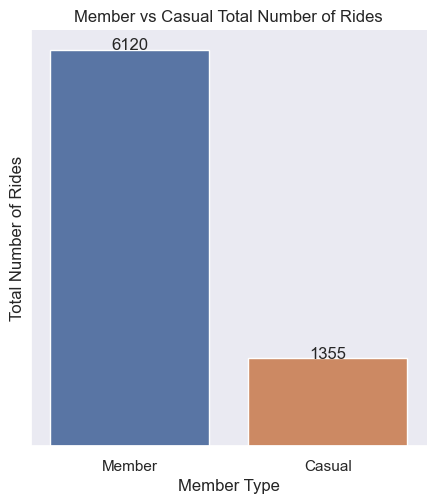

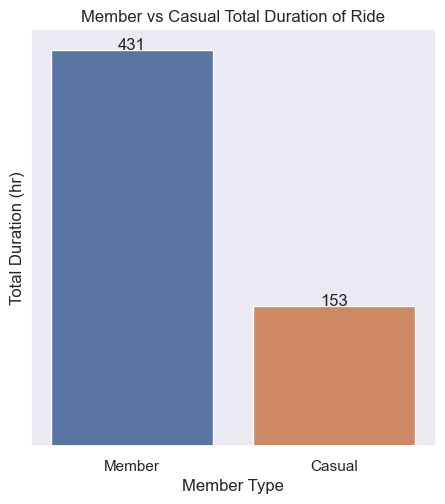

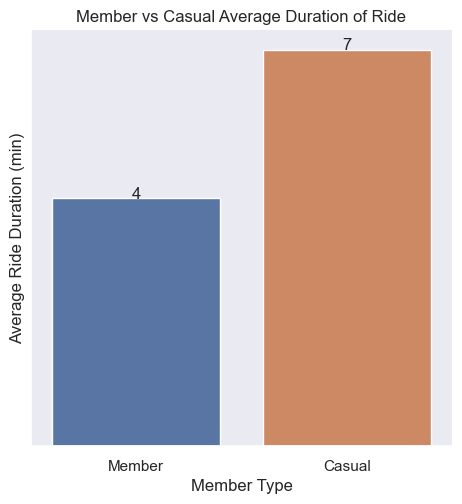

In [76]:
total_duration_hr = df[df['station_routes']== ("Ellis Ave & 60th St", "University Ave & 57th St")].groupby(['member_casual'])['ride_duration (hr)'].sum()
num_rides = df[df['station_routes']== ("Ellis Ave & 60th St", "University Ave & 57th St")].groupby(['member_casual'])['ride_duration (hr)'].count()
av_min_per_ride = total_duration_hr/ num_rides * 60

time_df = pd.DataFrame.from_dict({"Member": [total_duration_hr["member"], num_rides["member"], av_min_per_ride["member"]], "Casual": [total_duration_hr["casual"], num_rides["casual"], av_min_per_ride["casual"]]}, orient="index").reset_index()
time_df.columns = ['Member Type', 'Total Duration (hr)', 'Total Number of Rides', 'Average Ride Duration (min)']

# fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,12))

ax1 = sns.catplot(x='Member Type', y='Total Number of Rides', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Total Number of Rides")
ax2 = sns.catplot(x='Member Type', y='Total Duration (hr)', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Total Duration of Ride")
ax3 = sns.catplot(x='Member Type', y='Average Ride Duration (min)', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Average Duration of Ride")

for g in (ax1, ax2, ax3):
    ax = g.facet_axis(0, 0)
    ax.set(yticks=[])
#     ax.set(title="Total Direct Distance by Season")
    for p in ax.patches:
     # get the height of each bar
     height = p.get_height()
     # adding text to each bar
     ax.text(x = p.get_x()+(p.get_width()/2), 
     y = height, 
     s = "{:.0f}".format(height),  
     ha = "center")
        
        
plt.show()

3. Starting at: DuSable Lake Shore Dr & Monroe St

   Ending at: DuSable Lake Shore Dr & Monroe St

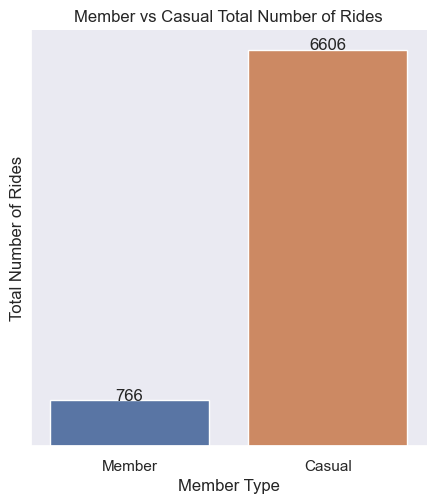

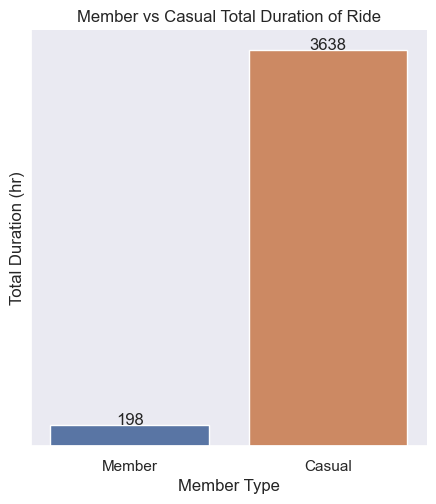

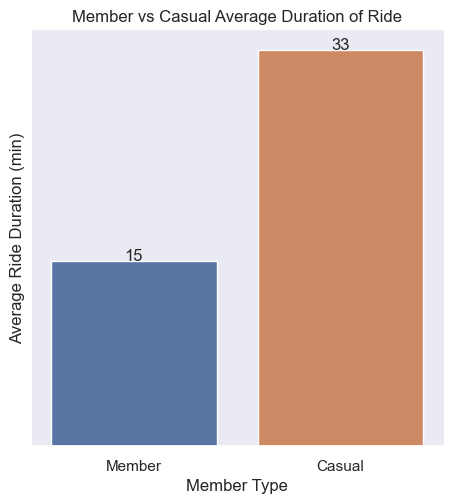

In [77]:
total_duration_hr = df[df['station_routes']== ("DuSable Lake Shore Dr & Monroe St", "DuSable Lake Shore Dr & Monroe St")].groupby(['member_casual'])['ride_duration (hr)'].sum()
num_rides = df[df['station_routes']== ("DuSable Lake Shore Dr & Monroe St", "DuSable Lake Shore Dr & Monroe St")].groupby(['member_casual'])['ride_duration (hr)'].count()
av_min_per_ride = total_duration_hr/ num_rides * 60

time_df = pd.DataFrame.from_dict({"Member": [total_duration_hr["member"], num_rides["member"], av_min_per_ride["member"]], "Casual": [total_duration_hr["casual"], num_rides["casual"], av_min_per_ride["casual"]]}, orient="index").reset_index()
time_df.columns = ['Member Type', 'Total Duration (hr)', 'Total Number of Rides', 'Average Ride Duration (min)']

ax1 = sns.catplot(x='Member Type', y='Total Number of Rides', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Total Number of Rides")
ax2 = sns.catplot(x='Member Type', y='Total Duration (hr)', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Total Duration of Ride")
ax3 = sns.catplot(x='Member Type', y='Average Ride Duration (min)', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Average Duration of Ride")

for g in (ax1, ax2, ax3):
    ax = g.facet_axis(0, 0)
    ax.set(yticks=[])
#     ax.set(title="Total Direct Distance by Season")
    for p in ax.patches:
     # get the height of each bar
     height = p.get_height()
     # adding text to each bar
     ax.text(x = p.get_x()+(p.get_width()/2), 
     y = height, 
     s = "{:.0f}".format(height),  
     ha = "center")
        
plt.show()

4. Starting at: Ellis Ave & 60th St

   Ending at: Ellis Ave & 55th St

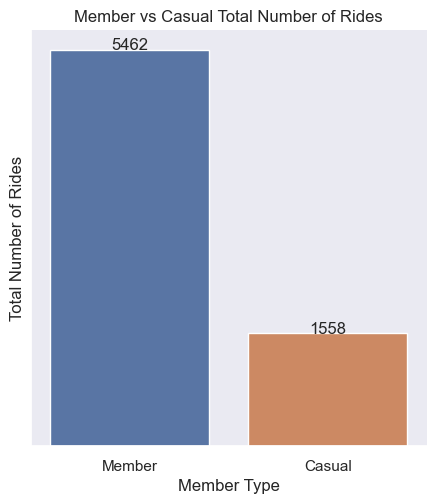

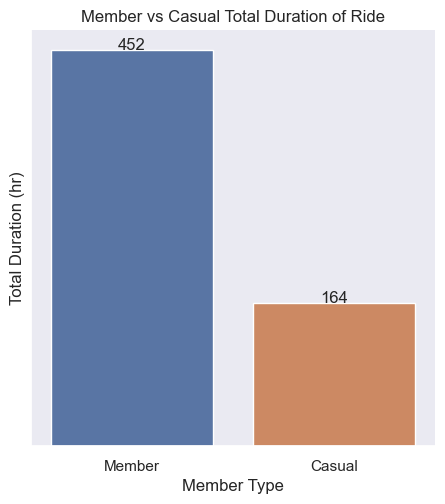

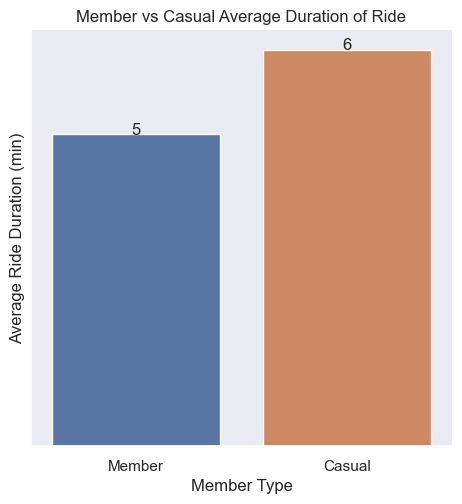

In [78]:
total_duration_hr = df[df['station_routes']== ("Ellis Ave & 60th St", "Ellis Ave & 55th St")].groupby(['member_casual'])['ride_duration (hr)'].sum()
num_rides = df[df['station_routes']== ("Ellis Ave & 60th St", "Ellis Ave & 55th St")].groupby(['member_casual'])['ride_duration (hr)'].count()
av_min_per_ride = total_duration_hr/ num_rides * 60

time_df = pd.DataFrame.from_dict({"Member": [total_duration_hr["member"], num_rides["member"], av_min_per_ride["member"]], "Casual": [total_duration_hr["casual"], num_rides["casual"], av_min_per_ride["casual"]]}, orient="index").reset_index()
time_df.columns = ['Member Type', 'Total Duration (hr)', 'Total Number of Rides', 'Average Ride Duration (min)']

# fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,12))

ax1 = sns.catplot(x='Member Type', y='Total Number of Rides', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Total Number of Rides")
ax2 = sns.catplot(x='Member Type', y='Total Duration (hr)', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Total Duration of Ride")
ax3 = sns.catplot(x='Member Type', y='Average Ride Duration (min)', data=time_df, kind='bar', errorbar=None).set(title="Member vs Casual Average Duration of Ride")

for g in (ax1, ax2, ax3):
    ax = g.facet_axis(0, 0)
    ax.set(yticks=[])
#     ax.set(title="Total Direct Distance by Season")
    for p in ax.patches:
     # get the height of each bar
     height = p.get_height()
     # adding text to each bar
     ax.text(x = p.get_x()+(p.get_width()/2), 
     y = height, 
     s = "{:.0f}".format(height),  
     ha = "center")
    
plt.show()

## Explore Numerical Variables

In [79]:
def explore_numerical_var(df,col):
    '''
    This function will return a summary of the numerical variable.
    The col represents a numerical column name.
    '''
    print('Summary statistics \n')
    print(df[col].apply([len,min,max,np.median,np.mean,np.std]))
    print('===============================')
    print('Missing values:  {}'.format(df[col].isnull().sum()))
    print('============================\n')
    plt.figure(figsize = (8,4))

# if column has too many values, simply sample and plot a subset
    if df[col].shape[0] < 10000:
        plt.subplot(1,2,1)
        plt.xlabel(df[col].name)
        plt.title('Boxplot')
        sns.boxplot(y=df[col])

        # plotting a histogram
        plt.subplot(1,2,2)
        sns.histplot(df[col],color='red',alpha=0.5)
        plt.title('Histogram')
        plt.tight_layout()
        plt.show()

In [80]:
numerical_var

Index(['start_lat', 'start_lng', 'end_lat', 'end_lng', 'ride_duration (hr)'], dtype='object')

In [81]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr),station_routes
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,Unknown,Unknown,Unknown,Unknown,41.93,-87.69,41.94,-87.72,casual,0.125278,"(Unknown, Unknown)"
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,Unknown,Unknown,Unknown,Unknown,41.89,-87.64,41.92,-87.64,casual,0.233889,"(Unknown, Unknown)"
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,Unknown,Unknown,Unknown,Unknown,41.97,-87.69,41.97,-87.66,casual,0.178889,"(Unknown, Unknown)"
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,Unknown,Unknown,Unknown,Unknown,41.94,-87.65,41.97,-87.69,casual,0.250833,"(Unknown, Unknown)"
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,Unknown,Unknown,Unknown,Unknown,41.85,-87.65,41.84,-87.66,casual,0.097778,"(Unknown, Unknown)"


### Explore Numerical Variables and fill in missing values

In [82]:
df.isnull().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
start_station_id         0
end_station_name         0
end_station_id           0
start_lat                0
start_lng                0
end_lat               6102
end_lng               6102
member_casual            0
ride_duration (hr)       0
station_routes           0
dtype: int64

In [83]:
df['start_lat'].isnull().sum(), df['start_lng'].isnull().sum(), df['end_lat'].isnull().sum(), df['end_lng'].isnull().sum()

(0, 0, 6102, 6102)

In [84]:
df_null_end_coord = df[df['end_lng'].isnull() | df['end_lat'].isnull()]

df_null_end_coord['rideable_type'].value_counts()

rideable_type
classic_bike    3287
docked_bike     2815
Name: count, dtype: int64

In [85]:
df_null_end_coord['member_casual'].value_counts()

member_casual
casual    5274
member     828
Name: count, dtype: int64

* Observation:
 Starting coordinates are always known because users can pick up a bike from a starting checkpoint and that is always known. However, we do not always know where they drop the bike. Maybe lost, maybe drop away from a checkpoint, etc... The ending points are not clear, likely due to user irresponsibility and not returning to proper place.
 
 Both electric and classic bikes share a fair number of missing end coordinate values, 3287 and 2815 respectively.
 Mostly casual members return bikes without and end coordinate. Perhaps members are more responsible about returning their bikes to checkpoints.
 
 We will omit those datapoints when we analyze.

In [86]:
df['end_lat'].describe()

count    5.717504e+06
mean     4.190318e+01
std      7.173348e-02
min      0.000000e+00
25%      4.188103e+01
50%      4.190000e+01
75%      4.193000e+01
max      4.218000e+01
Name: end_lat, dtype: float64

In [87]:
df.dropna(inplace=True)

In [88]:
df.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
ride_duration (hr)    0
station_routes        0
dtype: int64

In [89]:
# whenever you drop, it is advisable to reset index. Otherwise, indexes may be mislabeled
df.reset_index(drop=True) # must drop the old index

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr),station_routes
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,Unknown,Unknown,Unknown,Unknown,41.93,-87.69,41.940000,-87.720000,casual,0.125278,"(Unknown, Unknown)"
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,Unknown,Unknown,Unknown,Unknown,41.89,-87.64,41.920000,-87.640000,casual,0.233889,"(Unknown, Unknown)"
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,Unknown,Unknown,Unknown,Unknown,41.97,-87.69,41.970000,-87.660000,casual,0.178889,"(Unknown, Unknown)"
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,Unknown,Unknown,Unknown,Unknown,41.94,-87.65,41.970000,-87.690000,casual,0.250833,"(Unknown, Unknown)"
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,Unknown,Unknown,Unknown,Unknown,41.85,-87.65,41.840000,-87.660000,casual,0.097778,"(Unknown, Unknown)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5717499,57F5743A5828DA62,electric_bike,2023-07-14 19:17:13,2023-07-14 19:26:31,Unknown,Unknown,California Ave & Division St,13256,41.91,-87.68,41.903029,-87.697474,member,0.155000,"(Unknown, California Ave & Division St)"
5717500,2FF218D4C8F0EF1C,electric_bike,2023-07-14 19:16:13,2023-07-14 19:16:16,Unknown,Unknown,Unknown,Unknown,41.91,-87.68,41.910000,-87.680000,member,0.000833,"(Unknown, Unknown)"
5717501,2661FBD1F5A1C76D,electric_bike,2023-07-15 13:34:00,2023-07-15 13:43:13,Unknown,Unknown,Unknown,Unknown,41.94,-87.65,41.930000,-87.640000,member,0.153611,"(Unknown, Unknown)"
5717502,9CF4B70C23E033B1,electric_bike,2023-07-06 20:52:09,2023-07-06 21:01:13,Unknown,Unknown,Unknown,Unknown,41.91,-87.63,41.930000,-87.640000,member,0.151111,"(Unknown, Unknown)"


The missing values are dropped, but it does not make sense to analyze lat and lng separately. We should bundle them together and analyze them.

### Explore Numerical Variable: start_lat, start_lng

It doesn't make a lot of sense to explore these separately, so I will create a new column with these 2 as a tuple and explore them

In [90]:
# df['start coordinate'] =  df.apply(lambda row: (row['start_lat'], row['start_lng']), axis=1)
# df.head()
df['start_coord'] =  list(zip(df.start_lat, df.start_lng))
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr),station_routes,start_coord
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,Unknown,Unknown,Unknown,Unknown,41.93,-87.69,41.94,-87.72,casual,0.125278,"(Unknown, Unknown)","(41.93, -87.69)"
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,Unknown,Unknown,Unknown,Unknown,41.89,-87.64,41.92,-87.64,casual,0.233889,"(Unknown, Unknown)","(41.89, -87.64)"
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,Unknown,Unknown,Unknown,Unknown,41.97,-87.69,41.97,-87.66,casual,0.178889,"(Unknown, Unknown)","(41.97, -87.69)"
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,Unknown,Unknown,Unknown,Unknown,41.94,-87.65,41.97,-87.69,casual,0.250833,"(Unknown, Unknown)","(41.94, -87.65)"
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,Unknown,Unknown,Unknown,Unknown,41.85,-87.65,41.84,-87.66,casual,0.097778,"(Unknown, Unknown)","(41.85, -87.65)"


In [91]:
df.describe()

,start_lat,start_lng,end_lat,end_lng,ride_duration (hr)
count,5.717504e+06,5.717504e+06,5.717504e+06,5.717504e+06,5.717504e+06
mean,4.190298e+01,-8.764759e+01,4.190318e+01,-8.764763e+01,2.527242e-01
std,4.538713e-02,2.799961e-02,7.173348e-02,1.192788e-01,5.206091e-01
min,4.164000e+01,-8.792000e+01,0.000000e+00,-8.816000e+01,-1.725558e+02
25%,4.188103e+01,-8.766107e+01,4.188103e+01,-8.766136e+01,9.083333e-02
50%,4.190000e+01,-8.764414e+01,4.190000e+01,-8.764434e+01,1.597222e-01
75%,4.193000e+01,-8.763000e+01,4.193000e+01,-8.763000e+01,2.841667e-01
max,4.207000e+01,-8.752000e+01,4.218000e+01,0.000000e+00,2.022717e+02


In [92]:
df['start_coord'].unique()

array([(41.93, -87.69), (41.89, -87.64), (41.97, -87.69), ...,
       (41.80301666666666, -87.60662416666666),
       (41.86238916666667, -87.651125), (41.895655274, -87.672210813)],
      dtype=object)

### Explore Numerical Variable: end_coord

In [93]:
# df['new_col'] = list(zip(df.lat, df.long))
df['end_coord'] =  list(zip(df.end_lat, df.end_lng))

### Observation:

Calculate the direct distance from start_coord to end_coord to get a general idea of distance. Just as if Google maps, you type in city A to city B, it gives you shortest path, we can calculate as a reference.

In [94]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr),station_routes,start_coord,end_coord
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,Unknown,Unknown,Unknown,Unknown,41.93,-87.69,41.94,-87.72,casual,0.125278,"(Unknown, Unknown)","(41.93, -87.69)","(41.94, -87.72)"
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,Unknown,Unknown,Unknown,Unknown,41.89,-87.64,41.92,-87.64,casual,0.233889,"(Unknown, Unknown)","(41.89, -87.64)","(41.92, -87.64)"
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,Unknown,Unknown,Unknown,Unknown,41.97,-87.69,41.97,-87.66,casual,0.178889,"(Unknown, Unknown)","(41.97, -87.69)","(41.97, -87.66)"
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,Unknown,Unknown,Unknown,Unknown,41.94,-87.65,41.97,-87.69,casual,0.250833,"(Unknown, Unknown)","(41.94, -87.65)","(41.97, -87.69)"
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,Unknown,Unknown,Unknown,Unknown,41.85,-87.65,41.84,-87.66,casual,0.097778,"(Unknown, Unknown)","(41.85, -87.65)","(41.84, -87.66)"


### Explore Numerical Variable ride_duration (hr)

In [95]:
explore_numerical_var(df,'ride_duration (hr)')

Summary statistics 

len       5.717504e+06
min      -1.725558e+02
max       2.022717e+02
median    1.597222e-01
mean      2.527242e-01
std       5.206091e-01
Name: ride_duration (hr), dtype: float64
Missing values:  0



<Figure size 800x400 with 0 Axes>

The minimum ride duration is a negative, maybe the end time was recorded before the start time. Investigate

In [96]:
irregular_timestamps = df[(df["started_at"] > df["ended_at"]) | (df["started_at"] == df["ended_at"]) & (df["start_coord"] != df["end_coord"])]
irregular_timestamps

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr),station_routes,start_coord,end_coord
13139,162024EA2A5F23AC,electric_bike,2022-08-18 18:16:28,2022-08-18 18:16:28,Cottage Grove Ave & 51st St,TA1309000067,Cottage Grove Ave & 51st St,TA1309000067,41.803033,-87.606626,41.803038,-87.606615,member,0.000000,"(Cottage Grove Ave & 51st St, Cottage Grove Av...","(41.803033471, -87.606625676)","(41.803038, -87.606615)"
63114,8B5EDA7571220F96,electric_bike,2022-08-05 18:28:39,2022-08-05 18:28:39,Sheridan Rd & Irving Park Rd,13063,Sheridan Rd & Irving Park Rd,13063,41.954142,-87.654422,41.954245,-87.654406,member,0.000000,"(Sheridan Rd & Irving Park Rd, Sheridan Rd & I...","(41.954142, -87.65442233333333)","(41.954245, -87.654406)"
88522,968C67D0CE946110,electric_bike,2022-08-12 19:39:54,2022-08-12 19:39:54,Paulina St & Howard St,515,Unknown,Unknown,42.019137,-87.673541,42.020000,-87.670000,casual,0.000000,"(Paulina St & Howard St, Unknown)","(42.019137, -87.6735415)","(42.02, -87.67)"
90684,56053ADF859D6A68,electric_bike,2022-08-27 01:53:34,2022-08-27 01:53:34,Larrabee St & Armitage Ave,TA1309000006,Unknown,Unknown,41.918094,-87.643755,41.920000,-87.640000,casual,0.000000,"(Larrabee St & Armitage Ave, Unknown)","(41.91809366666666, -87.64375483333333)","(41.92, -87.64)"
90994,30A5715EABC20C70,electric_bike,2022-08-25 21:59:28,2022-08-25 21:59:28,Southport Ave & Waveland Ave,13235,Unknown,Unknown,41.948070,-87.664104,41.950000,-87.660000,casual,0.000000,"(Southport Ave & Waveland Ave, Unknown)","(41.94806966666667, -87.66410433333333)","(41.95, -87.66)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724028,68912B520CB9541C,electric_bike,2023-07-20 11:04:45,2023-07-20 11:04:44,Public Rack - Milwaukee Ave & Higgins Ave,1121.0,Public Rack - Milwaukee Ave & Higgins Ave,1121.0,41.968576,-87.761332,41.968596,-87.761209,member,-0.000278,"(Public Rack - Milwaukee Ave & Higgins Ave, Pu...","(41.968575835, -87.761331558)","(41.9685964, -87.7612092)"
729350,12D224BDACD65966,electric_bike,2023-07-25 17:51:16,2023-07-25 17:51:14,Sheffield Ave & Webster Ave,TA1309000033,Unknown,Unknown,41.921647,-87.653911,41.920000,-87.650000,member,-0.000556,"(Sheffield Ave & Webster Ave, Unknown)","(41.921647429, -87.653911114)","(41.92, -87.65)"
731475,64BF86DB62A97011,electric_bike,2023-07-22 10:05:44,2023-07-22 10:05:41,Unknown,Unknown,Unknown,Unknown,41.980000,-87.660000,41.980000,-87.660000,member,-0.000833,"(Unknown, Unknown)","(41.98, -87.66)","(41.98, -87.66)"
743979,C86F7B6C92A2B657,electric_bike,2023-07-11 00:06:54,2023-07-11 00:06:52,Unknown,Unknown,Unknown,Unknown,41.930000,-87.810000,41.930000,-87.810000,casual,-0.000556,"(Unknown, Unknown)","(41.93, -87.81)","(41.93, -87.81)"


Of the bikes with irregular timestamps (meaning timestamps that would lead to a 0 or negative ride duration), which bike types are they and are they ridden by casual riders or members?

In [97]:
# \.rename()columns={'rideable_type': 'Bike Type', 'ride_id': 'Number of Rides', 'member_casual': 'Member Type'}
irregular_timestamps_subset = irregular_timestamps.groupby(['rideable_type', 'member_casual'])[['ride_id']].count()\
.reset_index()\
.rename(columns={"ride_id":"Count", 'rideable_type': "Ride Type", 'member_casual': "Member Type"})

irregular_timestamps_subset.replace({'member':'Member', 'casual':'Casual'}, inplace=True)
irregular_timestamps_subset.replace({'classic_bike':'Classic Bike', 'electric_bike':'Electric Bike'}, inplace=True)

irregular_timestamps_subset

,Ride Type,Member Type,Count
0,Classic Bike,Casual,11
1,Classic Bike,Member,13
2,Electric Bike,Casual,256
3,Electric Bike,Member,294


Mostly electric bikes have the incorrect timestamp problem. Could be a bug in the hardware

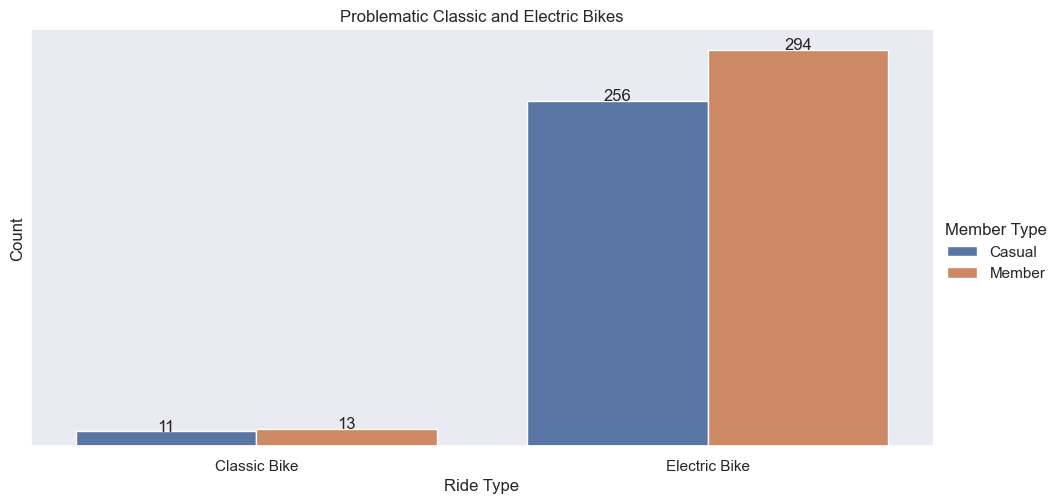

In [98]:
g = sns.catplot(data=irregular_timestamps_subset, kind='bar', x='Ride Type', y='Count', hue='Member Type', aspect=2)

ax = g.facet_axis(0, 0)

ax.set(yticks=[])
ax.set(title="Problematic Classic and Electric Bikes")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height, 
 s = "{:.0f}".format(height),  
 ha = "center")

In [99]:
explore_numerical_var(df[df['member_casual']=='member'],'ride_duration (hr)')

Summary statistics 

len       3.553223e+06
min      -1.725558e+02
max       2.499889e+01
median    1.419444e-01
mean      2.006554e-01
std       3.471113e-01
Name: ride_duration (hr), dtype: float64
Missing values:  0



<Figure size 800x400 with 0 Axes>

In [100]:
explore_numerical_var(df[df['member_casual']=='casual'],'ride_duration (hr)')

Summary statistics 

len       2.164281e+06
min      -1.004167e+00
max       2.022717e+02
median    1.969444e-01
mean      3.382085e-01
std       7.116445e-01
Name: ride_duration (hr), dtype: float64
Missing values:  0



<Figure size 800x400 with 0 Axes>

### Explore Numerical Variable direct_distance (km)

The following code calculates the direct distance between 2 coordinates. The direct distance is not the actual route or distance that the biker rode, but instead the distance between start and end coordinates so we have a "general approximation" of how far they rode.

In [101]:
direct_distance = []

for x in df[["start_coord", "end_coord"]].values:
  if np.isnan(x[0][0]) or np.isnan(x[0][1]) or np.isnan(x[1][0]) or np.isnan(x[1][1]):
    direct_distance.append(np.nan)
  else:
    direct_distance.append(gd.great_circle(x[0], x[1]).km) #this distance calculation is not as precisely accurate as gd.distance, but it is reasonably fast and good enough

df["direct_distance (km)"] = direct_distance
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr),station_routes,start_coord,end_coord,direct_distance (km)
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,Unknown,Unknown,Unknown,Unknown,41.93,-87.69,41.94,-87.72,casual,0.125278,"(Unknown, Unknown)","(41.93, -87.69)","(41.94, -87.72)",2.719290
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,Unknown,Unknown,Unknown,Unknown,41.89,-87.64,41.92,-87.64,casual,0.233889,"(Unknown, Unknown)","(41.89, -87.64)","(41.92, -87.64)",3.335853
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,Unknown,Unknown,Unknown,Unknown,41.97,-87.69,41.97,-87.66,casual,0.178889,"(Unknown, Unknown)","(41.97, -87.69)","(41.97, -87.66)",2.480190
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,Unknown,Unknown,Unknown,Unknown,41.94,-87.65,41.97,-87.69,casual,0.250833,"(Unknown, Unknown)","(41.94, -87.65)","(41.97, -87.69)",4.697742
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,Unknown,Unknown,Unknown,Unknown,41.85,-87.65,41.84,-87.66,casual,0.097778,"(Unknown, Unknown)","(41.85, -87.65)","(41.84, -87.66)",1.386578


In [102]:
explore_numerical_var(df,'direct_distance (km)');

Summary statistics 

len       5.717504e+06
min       0.000000e+00
max       9.815443e+03
median    1.544038e+00
mean      2.113021e+00
std       1.311340e+01
Name: direct_distance (km), dtype: float64
Missing values:  0



<Figure size 800x400 with 0 Axes>

In [103]:
explore_numerical_var(df[df['member_casual']=='casual'],'direct_distance (km)');

Summary statistics 

len       2.164281e+06
min       0.000000e+00
max       9.814083e+03
median    1.606895e+00
mean      2.127903e+00
std       1.171216e+01
Name: direct_distance (km), dtype: float64
Missing values:  0



<Figure size 800x400 with 0 Axes>

In [104]:
explore_numerical_var(df[df['member_casual']=='member'],'direct_distance (km)');

Summary statistics 

len       3.553223e+06
min       0.000000e+00
max       9.815443e+03
median    1.503694e+00
mean      2.103956e+00
std       1.389784e+01
Name: direct_distance (km), dtype: float64
Missing values:  0



<Figure size 800x400 with 0 Axes>

## Questions from observing Data:

* What are the members' average duration on the bike
* What are casual riders average duration on the bike

* Total minutes from all members
* Total minutes from all casual riders

* Total duration on each type of bike
* Total duration on each type of bike and separated by members and casual riders

In [105]:
member_total_time = df[(df['member_casual']=='member')]['ride_duration (hr)'].sum()
casual_total_time = df[(df['member_casual']=='casual')]['ride_duration (hr)'].sum()
print("Member Total Ride time:", member_total_time)
print("Casual Total Ride Time:", casual_total_time)

Member Total Ride time: 712973.5347222232
Casual Total Ride Time: 731978.2344444446


Members and casual riders have about the same total ride time annually, although there are many more members than casual riders.

In [106]:
num_member_rides = df[(df['member_casual']=='member')]['member_casual'].count()
num_casual_rides = df[(df['member_casual']=='casual')]['member_casual'].count()

print("Total Member Rides:", num_member_rides)
print("Total Casual Rides:", num_casual_rides)

Total Member Rides: 3553223
Total Casual Rides: 2164281


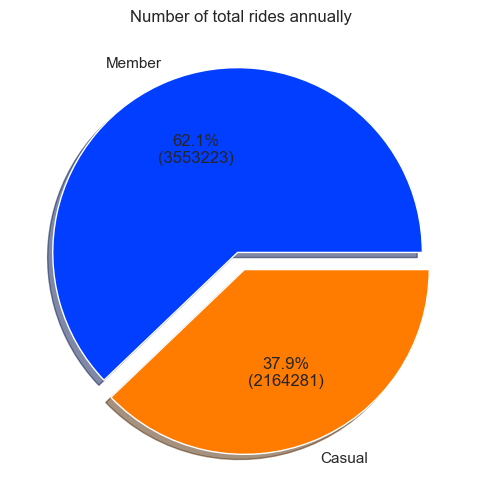

In [107]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

s = [num_member_rides, num_casual_rides]
plt.pie(s, labels=['Member', 'Casual'], colors=sns.color_palette("bright"), autopct=autopct_format(s), shadow=True, explode=[0.05, 0.05])
plt.title('Number of total rides annually')
plt.show()

In [108]:
av_mem = round((member_total_time / num_member_rides) * 60,2)
av_cas = round((casual_total_time / num_casual_rides) * 60,2)

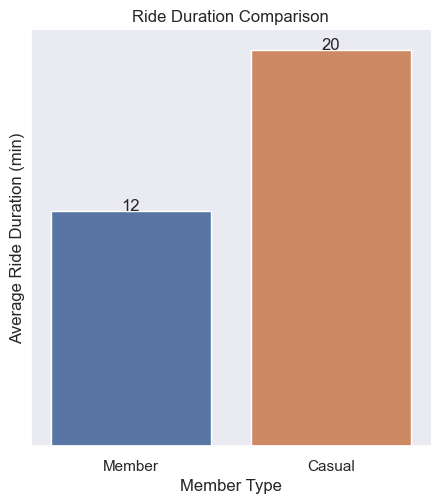

In [109]:
ride_time_df = pd.DataFrame.from_dict({"Member": av_mem, "Casual": av_cas}, orient="index").reset_index()
ride_time_df.columns = ['Member Type', 'Average Ride Duration (min)']

g = sns.catplot(ride_time_df,x='Member Type', y='Average Ride Duration (min)', kind='bar', errorbar=None).set(title='Average Ride Duration Member vs Casual');
ax = g.facet_axis(0, 0)

ax.set(yticks=[])
ax.set(title="Ride Duration Comparison")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height, 
 s = "{:.0f}".format(height),  
 ha = "center")

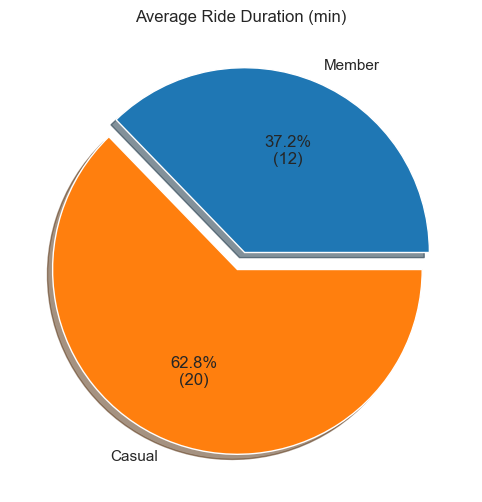

In [110]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

s = [av_mem, av_cas]
plt.title('Average Ride Duration (min)')
plt.pie(s, labels=['Member', 'Casual'], colors=sns.color_palette("tab10"), autopct=autopct_format(s), shadow=True, explode=[0.05, 0.05])
plt.show()

In [111]:
df[(df['member_casual']=='member')]['direct_distance (km)'].head()

54     0.000000
69     0.000000
113    1.386423
274    5.559754
470    2.771686
Name: direct_distance (km), dtype: float64

In [112]:
df[(df['member_casual']=='casual')].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr),station_routes,start_coord,end_coord,direct_distance (km)
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,Unknown,Unknown,Unknown,Unknown,41.93,-87.69,41.94,-87.72,casual,0.125278,"(Unknown, Unknown)","(41.93, -87.69)","(41.94, -87.72)",2.719290
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,Unknown,Unknown,Unknown,Unknown,41.89,-87.64,41.92,-87.64,casual,0.233889,"(Unknown, Unknown)","(41.89, -87.64)","(41.92, -87.64)",3.335853
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,Unknown,Unknown,Unknown,Unknown,41.97,-87.69,41.97,-87.66,casual,0.178889,"(Unknown, Unknown)","(41.97, -87.69)","(41.97, -87.66)",2.480190
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,Unknown,Unknown,Unknown,Unknown,41.94,-87.65,41.97,-87.69,casual,0.250833,"(Unknown, Unknown)","(41.94, -87.65)","(41.97, -87.69)",4.697742
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,Unknown,Unknown,Unknown,Unknown,41.85,-87.65,41.84,-87.66,casual,0.097778,"(Unknown, Unknown)","(41.85, -87.65)","(41.84, -87.66)",1.386578


In [113]:
member_total_distance = df[(df['member_casual']=='member')]['direct_distance (km)'].sum()
casual_total_distance = df[(df['member_casual']=='casual')]['direct_distance (km)'].sum()

member_total_distance, casual_total_distance

(7475825.434863665, 4605379.191580263)

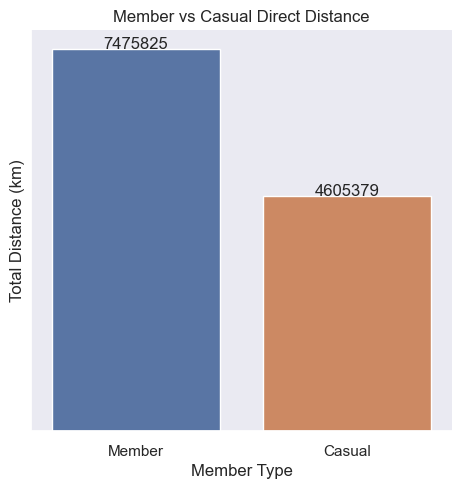

In [114]:
total_dist_df = pd.DataFrame.from_dict({"Member": member_total_distance, "Casual": casual_total_distance}, orient="index").reset_index()
total_dist_df.columns = ['Member Type', 'Total Distance (km)']
# total_dist_df

g = sns.catplot(total_dist_df,x='Member Type', y='Total Distance (km)', kind='bar', errorbar=None);
ax = g.facet_axis(0, 0)

ax.set(yticks=[])
ax.set(title="Member vs Casual Direct Distance")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height, 
 s = "{:.0f}".format(height),  
 ha = "center")

In [115]:
mem_avg_dist_per_ride = member_total_distance / num_member_rides
cas_avg_dist_per_ride = casual_total_distance / num_casual_rides

mem_avg_dist_per_ride, cas_avg_dist_per_ride

(2.1039561645479794, 2.1279026113431034)

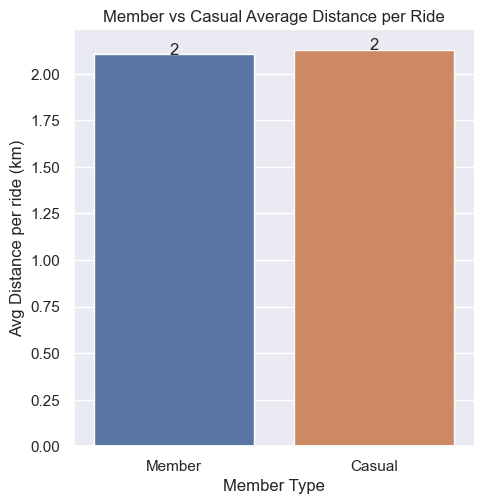

In [116]:
avg_dist_df = pd.DataFrame.from_dict({"Member": mem_avg_dist_per_ride, "Casual": cas_avg_dist_per_ride}, orient="index").reset_index()
avg_dist_df.columns = ['Member Type', 'Avg Distance per ride (km)']

g = sns.catplot(avg_dist_df,x='Member Type', y='Avg Distance per ride (km)', kind='bar', errorbar=None);
ax = g.facet_axis(0, 0)

ax.set(title="Member vs Casual Average Distance per Ride")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height, 
 s = "{:.0f}".format(height),  
 ha = "center")

### Observation:

Although there are more members, a casual rider rides over double the time per ride than a member. It's possible that a member has structured routes and therefore is efficient in their riding. A casual rider may spend time riding an inefficient route, riding a scenic route, and spend additional time to find where the dropoff point is.

In [117]:
df_bike_type=df.groupby(['rideable_type', 'member_casual'])[['ride_id']].count()\
.reset_index()\
.rename(columns={'rideable_type': 'Bike Type', 'ride_id': 'Number of Rides', 'member_casual': 'Member Type'})

df_bike_type

,Bike Type,Member Type,Number of Rides
0,classic_bike,casual,788695
1,classic_bike,member,1692295
2,docked_bike,casual,126089
3,electric_bike,casual,1249497
4,electric_bike,member,1860928


In [118]:
df_bike_type["Bike Type"].replace({'classic_bike': "Classic Bike", "docked_bike": "Docked Bike", "electric_bike": "Electric Bike"}, inplace=True)
df_bike_type["Member Type"].replace({'member': "Member", "casual": "Casual"}, inplace=True)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


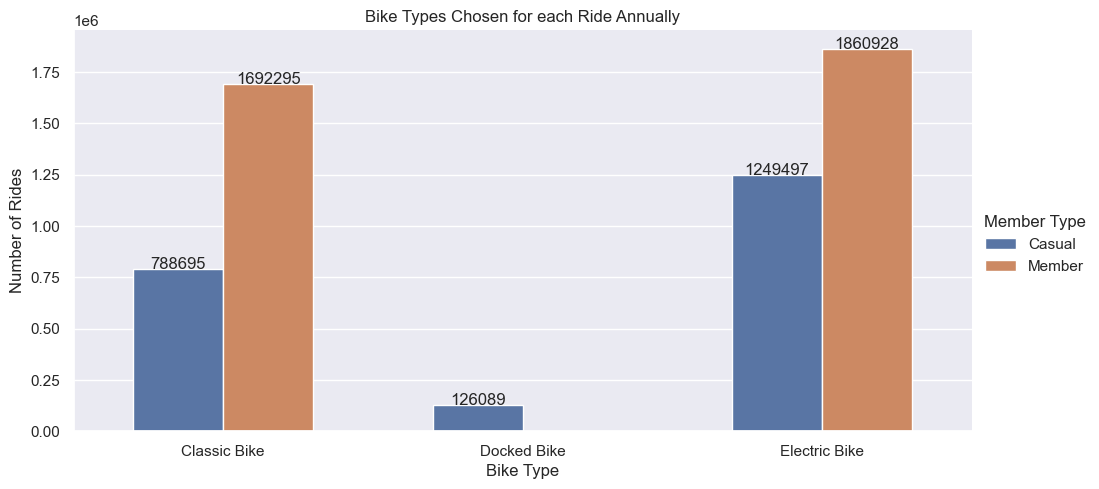

In [151]:
g = sns.catplot(df_bike_type,x='Bike Type', y='Number of Rides', kind='bar', width=0.6, errorbar=None, hue='Member Type', aspect=2);

sns.set(rc={"figure.figsize":(4,2)})
ax = g.facet_axis(0, 0)

ax.set(title="Bike Types Chosen for each Ride Annually")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+200, 
 s = "{:.0f}".format(height),  
 ha = "center")

It seems like members in general take more rides than casual riders, and in each categoriy of classic bike and electric bike, members take more rides. However, members never use the docked_bike type, all of their uses came from casual riders.

Could be that experienced riders know that docked bikes are not a good riding experience compared to other bike types.

In [120]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration (hr),station_routes,start_coord,end_coord,direct_distance (km)
0,550CF7EFEAE0C618,electric_bike,2022-08-07 21:34:15,2022-08-07 21:41:46,Unknown,Unknown,Unknown,Unknown,41.93,-87.69,41.94,-87.72,casual,0.125278,"(Unknown, Unknown)","(41.93, -87.69)","(41.94, -87.72)",2.719290
1,DAD198F405F9C5F5,electric_bike,2022-08-08 14:39:21,2022-08-08 14:53:23,Unknown,Unknown,Unknown,Unknown,41.89,-87.64,41.92,-87.64,casual,0.233889,"(Unknown, Unknown)","(41.89, -87.64)","(41.92, -87.64)",3.335853
2,E6F2BC47B65CB7FD,electric_bike,2022-08-08 15:29:50,2022-08-08 15:40:34,Unknown,Unknown,Unknown,Unknown,41.97,-87.69,41.97,-87.66,casual,0.178889,"(Unknown, Unknown)","(41.97, -87.69)","(41.97, -87.66)",2.480190
3,F597830181C2E13C,electric_bike,2022-08-08 02:43:50,2022-08-08 02:58:53,Unknown,Unknown,Unknown,Unknown,41.94,-87.65,41.97,-87.69,casual,0.250833,"(Unknown, Unknown)","(41.94, -87.65)","(41.97, -87.69)",4.697742
4,0CE689BB4E313E8D,electric_bike,2022-08-07 20:24:06,2022-08-07 20:29:58,Unknown,Unknown,Unknown,Unknown,41.85,-87.65,41.84,-87.66,casual,0.097778,"(Unknown, Unknown)","(41.85, -87.65)","(41.84, -87.66)",1.386578


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5717504 entries, 0 to 767649
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ride_id               object 
 1   rideable_type         object 
 2   started_at            object 
 3   ended_at              object 
 4   start_station_name    object 
 5   start_station_id      object 
 6   end_station_name      object 
 7   end_station_id        object 
 8   start_lat             float64
 9   start_lng             float64
 10  end_lat               float64
 11  end_lng               float64
 12  member_casual         object 
 13  ride_duration (hr)    float64
 14  station_routes        object 
 15  start_coord           object 
 16  end_coord             object 
 17  direct_distance (km)  float64
dtypes: float64(6), object(12)
memory usage: 828.8+ MB


### Which months are the highest usage?

In [122]:
monthly_rides = df.groupby([pd.DatetimeIndex(df.started_at).month, 'rideable_type', 'member_casual'])['ride_id'].count()\
.reset_index()\
.rename(columns={'started_at': 'Month', 'ride_id': 'Number of Rides', 'rideable_type':'Type', 'member_casual': 'Member Type'})

monthly_rides

,Month,Type,Member Type,Number of Rides
0,1,classic_bike,casual,13862
1,1,classic_bike,member,76361
2,1,docked_bike,casual,1682
3,1,electric_bike,casual,24361
4,1,electric_bike,member,73908
5,2,classic_bike,casual,15484
6,2,classic_bike,member,74332
7,2,docked_bike,casual,2151
8,2,electric_bike,casual,25287
9,2,electric_bike,member,73075


In [123]:
monthly_rides["Type"].replace({'classic_bike': "Classic Bike", "docked_bike": "Docked Bike", "electric_bike": "Electric Bike"}, inplace=True)
monthly_rides["Member Type"].replace({'member': "Member", "casual": "Casual"}, inplace=True)

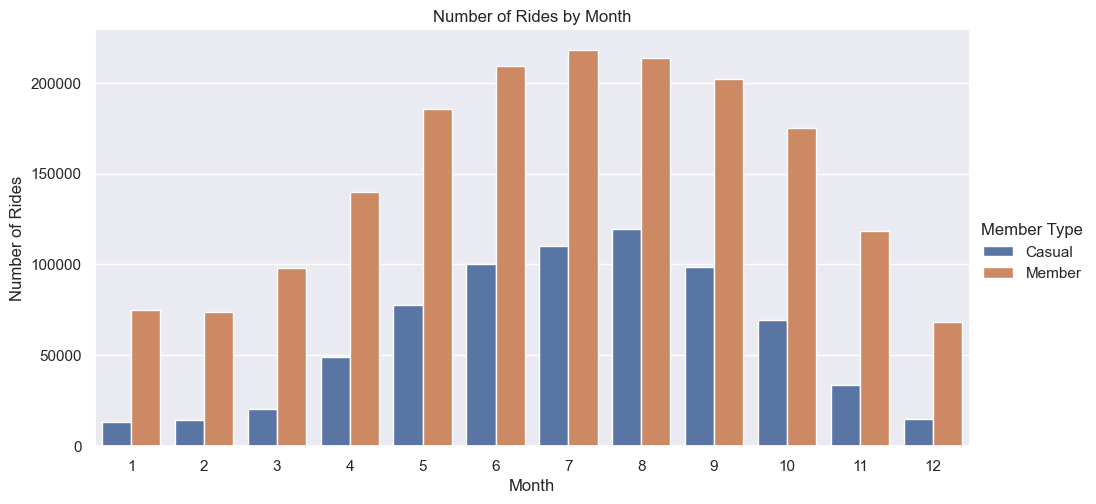

In [124]:
g = sns.catplot(monthly_rides,x='Month', y='Number of Rides', kind='bar', errorbar=None, aspect=2, hue='Member Type');
g.set(title="Number of Rides by Month")

Most number of riders in the warmer months May to September. In colder months, overall there are still riders. But we must consider the region: some regions are still warm enough for a bike in winter and may have constant seasonal use. Others maybe no riders in the winter.

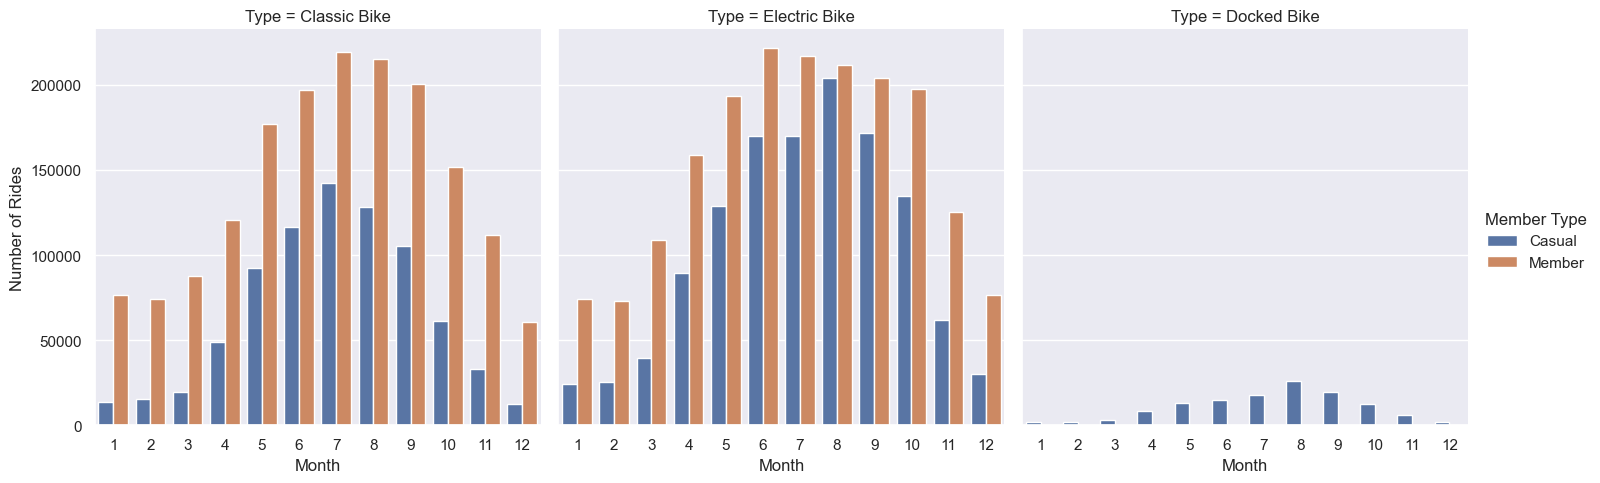

In [125]:
g = sns.catplot(monthly_rides,x='Month', y='Number of Rides', 
            kind='bar', errorbar=None, col="Type", 
            col_order=['Classic Bike', 'Electric Bike', 'Docked Bike'], hue="Member Type");
# g.set(title="Bike Types by Month")

Looks like docked bikes are almost never used and classic and electric are used commonly. They seem to follow the same trends month to month.

### Which months are the highest usage?

In [126]:
pd.DatetimeIndex(df.started_at).hour

Index([21, 14, 15,  2, 20, 13, 14, 20, 21, 23,
       ...
       13,  7, 11,  1, 15, 19, 19, 13, 20, 18],
      dtype='int32', name='started_at', length=5717504)

In [127]:
hourly_rides = df.groupby([pd.DatetimeIndex(df.started_at).hour,"member_casual"])['ride_id'].count()\
.reset_index()\
.rename(columns={'started_at': 'Hour', 'ride_id': 'Number of Rides', 'member_casual':"Member Type"})

hourly_rides

,Hour,Member Type,Number of Rides
0,0,casual,40841
1,0,member,36132
2,1,casual,26503
3,1,member,22008
4,2,casual,15994
5,2,member,12669
6,3,casual,9084
7,3,member,7990
8,4,casual,6411
9,4,member,8751


In [128]:
hourly_rides.replace({"member": "Member", "casual": "Casual"}, inplace=True)

<Figure size 900x600 with 0 Axes>

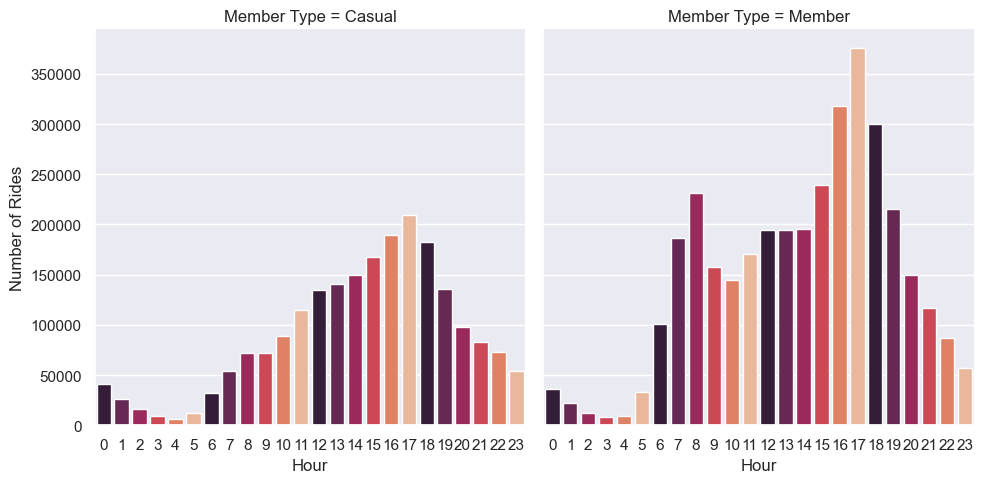

In [129]:
plt.figure(figsize=(9,6))
g = sns.catplot(hourly_rides,x='Hour', y='Number of Rides', palette=sns.color_palette("rocket"), kind='bar', errorbar=None, col="Member Type");
plt.show()

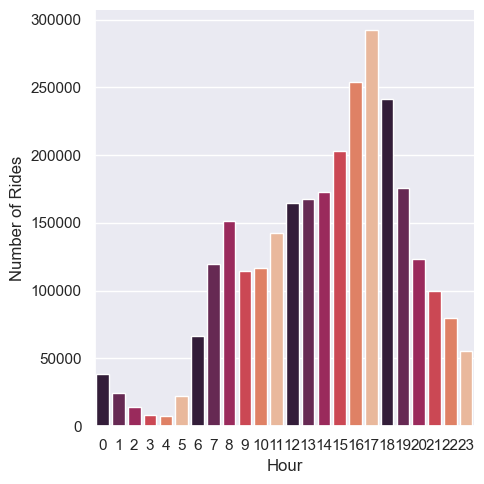

In [131]:
sns.catplot(hourly_rides,x='Hour', y='Number of Rides', kind='bar', palette=sns.color_palette("rocket"), errorbar=None);

Most usage from 8 AM to 6 PM. This makes sense as these are work / daylight hours.

### Seasonal Analysis

In [132]:
total_num_rides_season = df.groupby([pd.DatetimeIndex(df.started_at).month % 12 //3 + 1,"member_casual"])['ride_id'].count()\
.reset_index()\
.rename(columns={'started_at': 'Season', 'ride_id': 'Total number of Rides', 'member_casual': 'Member Type'})

total_num_rides_season.replace({"member": "Member", "casual": "Casual", 1:"Winter", 2:"Spring", 3:"Summer", 4:"Fall"}, inplace=True)
total_num_rides_season.replace({"member": "Member", "casual": "Casual"}, inplace=True)

total_num_rides_season

,Season,Member Type,Total number of Rides
0,Winter,Casual,127618
1,Winter,Member,434563
2,Spring,Casual,442534
3,Spring,Member,846233
4,Summer,Casual,988856
5,Summer,Member,1281358
6,Fall,Casual,605273
7,Fall,Member,991069


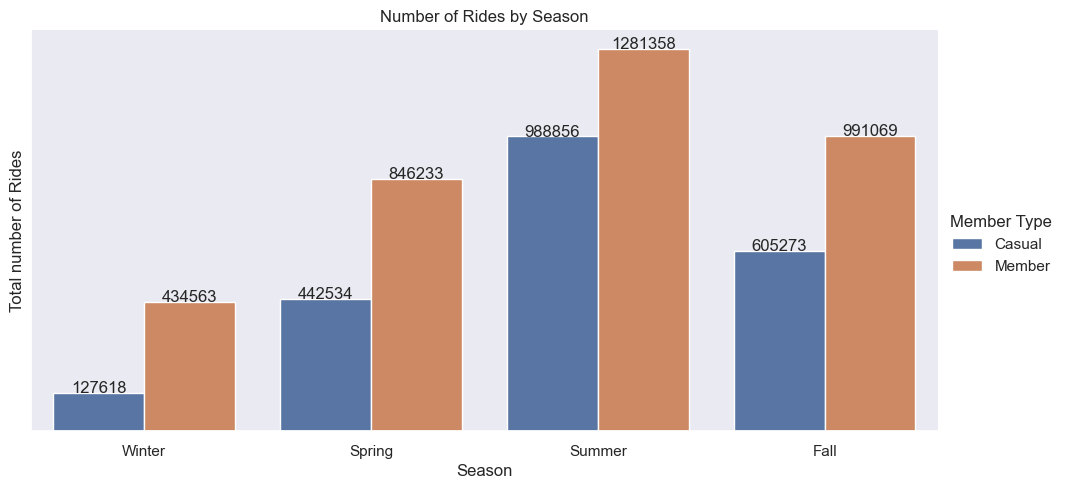

In [133]:
g = sns.catplot(total_num_rides_season,x='Season', y='Total number of Rides', kind='bar', width=0.8, errorbar=None, hue="Member Type", aspect=2);

sns.set(rc={"figure.figsize":(8,4)})
ax = g.facet_axis(0, 0)

ax.set(yticks=[])
ax.set(title="Number of Rides by Season")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+200, 
 s = "{:.0f}".format(height),  
 ha = "center")

In [134]:
season_ride_duration = df.groupby([pd.DatetimeIndex(df.started_at).month % 12 //3 + 1,"member_casual"])['ride_duration (hr)'].sum()\
.reset_index()\
.rename(columns={'started_at': 'Season', 'member_casual': 'Member Type', 'ride_duration (hr)': 'Ride Duration (hr)'})

season_ride_duration.replace({"member": "Member", "casual": "Casual", 1:"Winter", 2:"Spring", 3:"Summer", 4:"Fall"}, inplace=True)
season_ride_duration.replace({"member": "Member", "casual": "Casual"}, inplace=True)

season_ride_duration

,Season,Member Type,Ride Duration (hr)
0,Winter,Casual,30440.931667
1,Winter,Member,74757.402222
2,Spring,Casual,151323.108611
3,Spring,Member,164313.665000
4,Summer,Casual,361612.816944
5,Summer,Member,278694.408333
6,Fall,Casual,188601.377222
7,Fall,Member,195208.059167


In [135]:
season_ride_duration

,Season,Member Type,Ride Duration (hr)
0,Winter,Casual,30440.931667
1,Winter,Member,74757.402222
2,Spring,Casual,151323.108611
3,Spring,Member,164313.665000
4,Summer,Casual,361612.816944
5,Summer,Member,278694.408333
6,Fall,Casual,188601.377222
7,Fall,Member,195208.059167


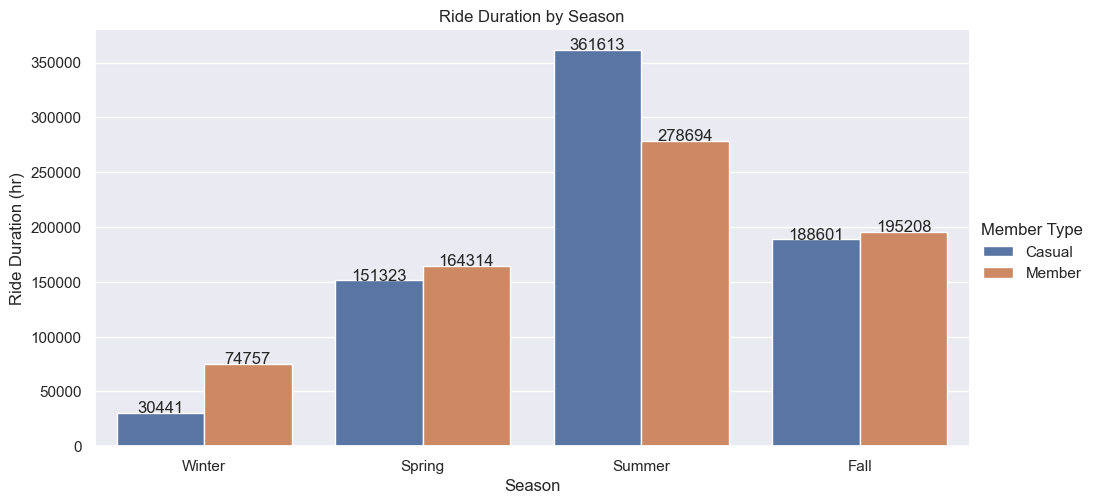

In [136]:
g = sns.catplot(season_ride_duration,x='Season', y='Ride Duration (hr)', kind='bar', errorbar=None, width=0.8, hue="Member Type", aspect=2);

ax = g.facet_axis(0, 0)

ax.set(title="Ride Duration by Season")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+200, 
         
 s = "{:.0f}".format(height),  
 ha = "center")

In [137]:
direct_distance_season = df.groupby([pd.DatetimeIndex(df.started_at).month % 12 //3 + 1,"member_casual"])['direct_distance (km)'].sum()\
.reset_index()\
.rename(columns={'started_at': 'Season', 'member_casual': 'Member Type', 'direct_distance (km)': 'Direct Distance (km)'})

direct_distance_season.replace({"member": "Member", "casual": "Casual", 1:"Winter", 2:"Spring", 3:"Summer", 4:"Fall"}, inplace=True)
direct_distance_season.replace({"member": "Member", "casual": "Casual"}, inplace=True)

direct_distance_season

,Season,Member Type,Direct Distance (km)
0,Winter,Casual,2.174001e+05
1,Winter,Member,7.754964e+05
2,Spring,Casual,9.155666e+05
3,Spring,Member,1.736864e+06
4,Summer,Casual,2.193764e+06
5,Summer,Member,2.877828e+06
6,Fall,Casual,1.278649e+06
7,Fall,Member,2.085637e+06


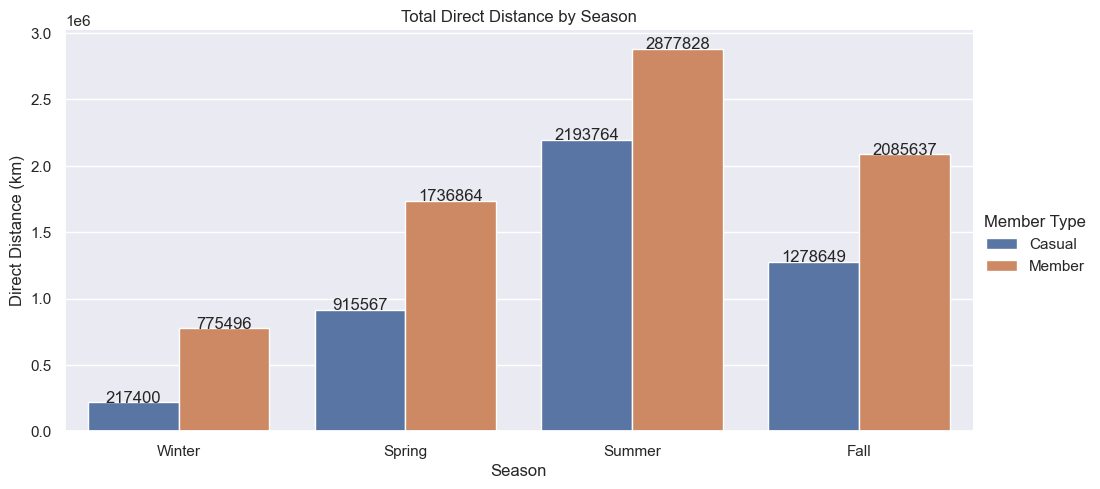

In [138]:
g = sns.catplot(direct_distance_season,x='Season', y='Direct Distance (km)', kind='bar', errorbar=None, width=0.8, hue="Member Type", aspect=2);

ax = g.facet_axis(0, 0)

ax.set(title="Total Direct Distance by Season")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+200, 
 s = "{:.0f}".format(height),  
 ha = "center")

As expected, the most number of rides, distance covered, and time spent occurs during the summer. Following it is Fall, Spring, and finally Winter.

In [139]:
df["Day Name"] = pd.DatetimeIndex(df.started_at).day_name()

In [140]:
df["Weekday"] = pd.DatetimeIndex(df.started_at).weekday

In [141]:
day_of_week_rides = df.groupby(["Day Name", "Weekday", "member_casual"])['ride_id'].count()\
.reset_index()\
.rename(columns={'started_at': 'Day of Week', 'ride_id': 'Count', 'member_casual': 'Member Type'})

day_of_week_rides.replace({"member": "Member", "casual": "Casual"}, inplace=True)

day_of_week_rides

,Day Name,Weekday,Member Type,Count
0,Friday,4,Casual,334328
1,Friday,4,Member,516612
2,Monday,0,Casual,257367
3,Monday,0,Member,501368
4,Saturday,5,Casual,434113
5,Saturday,5,Member,461403
6,Sunday,6,Casual,331637
7,Sunday,6,Member,386424
8,Thursday,3,Casual,288654
9,Thursday,3,Member,569774


In [142]:
day_of_week_rides.sort_values('Weekday', inplace=True)

In [143]:
day_type = []

for value in day_of_week_rides['Weekday'].values:
  if value >= 5:
    day_type.append('Weekend')
  else:
    day_type.append('Weekday')
    
day_of_week_rides['Day_type'] = day_type
day_of_week_rides

,Day Name,Weekday,Member Type,Count,Day_type
2,Monday,0,Casual,257367,Weekday
3,Monday,0,Member,501368,Weekday
10,Tuesday,1,Casual,256326,Weekday
11,Tuesday,1,Member,551845,Weekday
12,Wednesday,2,Casual,261856,Weekday
13,Wednesday,2,Member,565797,Weekday
8,Thursday,3,Casual,288654,Weekday
9,Thursday,3,Member,569774,Weekday
0,Friday,4,Casual,334328,Weekday
1,Friday,4,Member,516612,Weekday


In [144]:
weekday_weekend_avg_df = day_of_week_rides.groupby(['Day_type', 'Member Type'])[['Count']].mean()\
  .reset_index()\
.rename(columns={'Count': 'Average Count', 'Day_type': 'Day Type'})
weekday_weekend_avg_df.replace({"weekday": "Weekday", "weekend": "Weekend"}, inplace=True)
weekday_weekend_avg_df

,Day Type,Member Type,Average Count
0,Weekday,Casual,279706.2
1,Weekday,Member,541079.2
2,Weekend,Casual,382875.0
3,Weekend,Member,423913.5


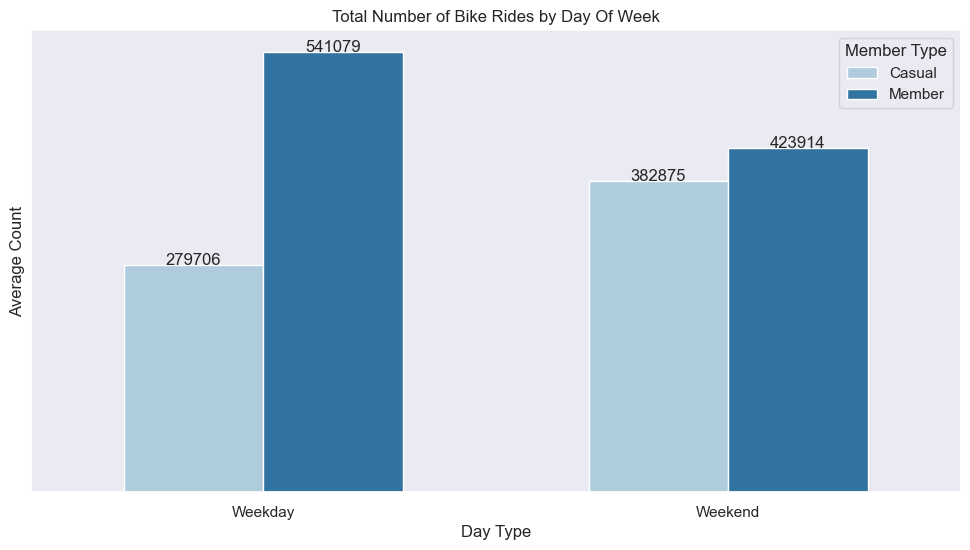

In [145]:
# sns.barplot(weekday_weekend_avg_df,x='Day_type', y='Average_Count', errorbar=None);

sns.set(rc={"figure.figsize":(12,6)})
ax=sns.barplot(data=weekday_weekend_avg_df, x='Day Type',y='Average Count', palette=sns.color_palette("Paired"),width=0.6, hue="Member Type")
ax.set(yticks=[])
ax.set(title="Total Number of Bike Rides by Day Of Week")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+200, 
 s = "{:.0f}".format(height),  
 ha = "center")

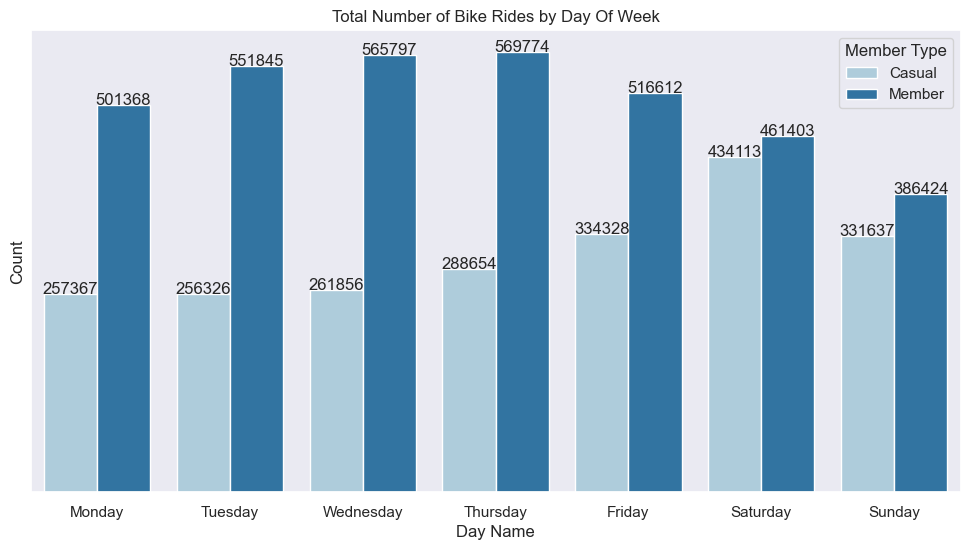

In [146]:
# sns.catplot(day_of_week_rides,x='Day_of_Week', y='Count', kind='bar', errorbar=None);
sns.set(rc={"figure.figsize":(12,6)})
ax=sns.barplot(data=day_of_week_rides, x='Day Name',y='Count',palette=sns.color_palette("Paired"),width=0.8,hue="Member Type")
ax.set(yticks=[])
ax.set(title="Total Number of Bike Rides by Day Of Week")
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), 
 y = height+200, 
 s = "{:.0f}".format(height),  
 ha = "center")
#Monday=0, Sunday=6

Contrary to expectation, there is the least rides on Sunday. Monday through Saturday are pretty consistent, with Monday being the least of those days and Saturday being the most of those days.

### We would like to check if there are significant differences in average ridership between weekday and weekends. We use a t-test

Null Hypothesis: Weekends and weekdays have the same average ridership.

Alt Hypothesis: Weekends have the lower ridership than weekdays.

We run a T-Test to determine significance.

In [147]:
day_of_week_rides

,Day Name,Weekday,Member Type,Count,Day_type
2,Monday,0,Casual,257367,Weekday
3,Monday,0,Member,501368,Weekday
10,Tuesday,1,Casual,256326,Weekday
11,Tuesday,1,Member,551845,Weekday
12,Wednesday,2,Casual,261856,Weekday
13,Wednesday,2,Member,565797,Weekday
8,Thursday,3,Casual,288654,Weekday
9,Thursday,3,Member,569774,Weekday
0,Friday,4,Casual,334328,Weekday
1,Friday,4,Member,516612,Weekday


In [148]:
import scipy.stats

# Create two arrays of data
weekday = day_of_week_rides[(day_of_week_rides['Day_type'] == 'Weekday')]['Count'].values
weekend = day_of_week_rides[(day_of_week_rides['Day_type'] == 'Weekend')]['Count'].values

t_statistic, p_value = scipy.stats.ttest_ind(weekday, weekend)

# Interpret the results
print(t_statistic)
print(p_value)
if p_value < 0.05:
  print("There is a significant difference between the means of the two groups.")
else:
  print("There is no significant difference between the means of the two groups.")

0.09433763704451216
0.9263978690100253
There is no significant difference between the means of the two groups.


Since the p value (p=0.8179) was not less than 0.05, there is not enough evidence to reject the null hypothesis. We fail to reject the null hypothesis, and therefore there is no significant difference in ridership between the weekday and weekends.

Also, it looks like Saturday is the peak day for ridership, so we want to make sure we have enough bikes during that time.

### Conclusions: 

We have a number of observations from the data which begins from 8/1/2022 to 7/31/2023

* The electric bike is the most commonly used bike, with over 3.1 million rides annually. The classic bike is the second most commonly used bike, with nearly 2.5 million rides annually. Finally is the docked bike, which has only about 129,000 rides annually.

* We have more annual members than casual members. We have about 3.6 million annual members and about 2.2 million casual riders.

* The most commonly ridden routes are (starting station, ending station):

    ** (Streeter Dr & Grand Ave, Streeter Dr & Grand Ave)
    
        ***Casual riders ride much more than members here. Probably casually riders use this as a tourist attraction and circle around to back where they started once they are finished.
        
    ** (Ellis Ave & 60th St, University Ave & 57th St)
    
        ***Members ride this route much more than casual riders. Possible this is a work route or a commonly used route to travel.
        
    ** (DuSable Lake Shore Dr & Monroe St, DuSable Lake Shore Dr & Monroe St)
        *** Members ride this route much more than casual riders.
        
    ** (Ellis Ave & 60th St, Ellis Ave & 55th St)
        *** Members ride this route much more than casual riders.
        
    ** In all 4 of the top routes, casual riders spend more time on their bike. 
    
    
* The top 4 most common start and end stations are 

    ** Streeter Dr & Grand Ave
    
    ** DuSable Lake Shore Dr & Monroe St
    
    ** Michigan Ave & Oak St
    
    ** DuSable Lake Shore Dr & North Blvd
    
    
* The average ride duration is 15 minutes. Members on average spend 12 minutes on their ride, casual riders spend on average nearly 20 minutes on their ride.

* Members ride about 7.5 million km in total distance annually from their starting to ending coordinate, while casual riders ride about 4.6 million in distance annually.

* The average ride distance from starting coordinate to ending coordinate is 2.1 km for both members and casual riders.

* There is a bug in electric bikes (about 450 of them) where there it is not registering start and end time correctly. It may register start time after the end or vice versa. Of the classic bikes 24 have this problem.

* Members and casual riders have about the same total ride time annually, although there are many more members than casual riders.

* Members have 3.55 million annual rides, casual riders have 2.16 million annual rides.

* Members average about 12 minutes per ride, while casual riders average about 20 minutes per ride.

* From May to September are the highest number of monthly rides, which makes sense for the warmer season. Over these months, electric bikes are most popular and classic bikes are a close second. Docked bikes are not used much.

* In terms of popularity, the season goes from summer, fall, spring, then winter.

* Members see consistently higher usage of bikes than casual riders over the course of all months.

* The hours of highest rate usage are 8 AM to 7 PM with 4-6 PM being the highest usage hours. Casual and members show the same patterns of usage.

* All days of the week have similar usage, the exception of Sunday having lowest usage.

* There is no statistically significant difference between weekday and weekend usage.

### Recommendations

* In the future, we can do away with the docked bike if there are no special benefits to having them. They are not chosen often by riders, member or casual.

* We may want to look into electric bikes, because there are problems with registering starting and ending times accurately sometimes.

* We have 4 routes which are most commonly traveled

    ** (Streeter Dr & Grand Ave, Streeter Dr & Grand Ave)
    
    ** (Ellis Ave & 60th St, University Ave & 57th St)
    
    ** (DuSable Lake Shore Dr & Monroe St, DuSable Lake Shore Dr & Monroe St)
    
    ** (Ellis Ave & 60th St, Ellis Ave & 55th St)
    
    ** We can place flyers on these routes to advertise. The first route of Streeter Dr. & Grand Ave has 9141 casual rides per year compared to only 1455 member rides per year, so if we wish to do a conversion from casual to member, we can place flyers here. 
* The top 4 most common start and end stations are 

    ** Streeter Dr & Grand Ave
    
    ** DuSable Lake Shore Dr & Monroe St
    
    ** Michigan Ave & Oak St
    
    ** DuSable Lake Shore Dr & North Blvd
    
    ** At these start and end stations, we can place flyers to convert casual riders to members.
    
    ** While an average ride is about 2.1 km for both members and casual riders, members spend only an average of 12 minutes per ride while casual riders spend an average of 20 minutes per ride. We can advertise to casual riders showing their time savings when they become a member, by showing statistics that members are more organized and efficient once they get familiar with routes.
    
    ** Next steps: Perhaps try to find data on financial cost of membership so we can analyze how much a person can save by buying an annual membership based on usage. Then we can advertise on that.

    